Import

In [1]:
from langchain_mistralai import ChatMistralAI
import os
from dotenv import load_dotenv
from abc import ABC, abstractmethod
from pydantic import BaseModel, Field, create_model
from typing import Optional, List, Literal, Annotated, TypedDict, Union
from datetime import datetime, timedelta
from aenum import Enum as Aenum
from enum import Enum
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import END, StateGraph, START, MessagesState
import requests
import urllib3
import pandas as pd

from PySide6.QtWidgets import QGroupBox, QVBoxLayout, QToolButton, QWidget, QSizePolicy, QFrame, QTextBrowser, QLineEdit, QPushButton, QHBoxLayout, QApplication, QFileDialog, QLabel, QSpacerItem, QScrollArea, QGraphicsOpacityEffect, QGraphicsDropShadowEffect
from PySide6.QtCore import Qt, QPropertyAnimation, QEasingCurve, QThread, QMetaObject, Qt, Q_ARG, QTimer, QSize, QParallelAnimationGroup, Slot, QObject, Signal
from PySide6.QtWidgets import QFileDialog, QMessageBox
from PySide6.QtGui import QMovie, QPixmap
import json
import markdown2
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from langgraph.graph.message import add_messages
from matplotlib.figure import Figure

import sys
import warnings

Modèle de LLM

In [2]:
#Chargement des variables d'environnement
load_dotenv()

os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")

#Chargement des modeles
model_codestral = ChatMistralAI(model="codestral-latest", temperature = 0)
model_mistral_medium = ChatMistralAI(model="mistral-medium-latest", temperature = 0)


Requête

In [3]:
class fonctions_existantes(Aenum):
    _init_ = 'value __doc__'
    PLUS_OCCURENT = "plus_occurent", "Permet de connaître l'élément le plus occurent parmi les arguments proposés. Arguments : Liste des clés de dataFrame concernées"
    INFORMATION_EN_FONCTION_AUTRE = "information_en_fonction_autre", "Permet d'exprimer une information en fonction d'une autre information. Premier argument : Moment où les autres dataFrame sont définis par rapport à l'élément de DataFrame dont ils dépendent. Peut prendre comme valeur : ""avant"" ou ""pendant"" Deuxième argument : élément de dataFrame dont dépendent les autres informations. Toujours mettre une variable temporelle en premier argument. Autres arguments : Les élément de dataFrame exprimées selon le premier argument"
    FILTRER_VALEUR = "filtrer_valeur", "Permet de filtrer des colonnes de DataFrame de sorte à ne les faire correspondre qu'à une valeur. Lorsque FILTRER_VALEUR est utilisé, le premier élément de DataFrame doit toujours être associé à <strong id = ""1"">des temps de cycle</strong> ou  <strong id = ""1"">des temps de coupe </strong> et il doit contenir les attributs start et end. Premier argument : Valeur correspondant à l'élément filtré.  2ème : Elément de dataFrame contenant l'élément filtré. 3ème arguments : Elément de dataFrame filtrée "
    FILTRER_COMPARAISON = "filtrer_comparaison", "Permet de filtrer des colonnes de DataFrame de sorte à ne garder que les valeurs comprises entre deux valeurs précises. Argument 1 : Colonne de dataFrame. Argument 2 : Valeur minimale. Si cette valeur est - infini, mettre -inf. Si nous voulons mettre une date, mettre la valeur minimale de date. Argument 3 : Valeur maximale. Si cette valeur est + infini, mettre +inf. Si nous voulons mettre une date, mettre la valeur maximale de date"
    CREER_GRAPHIQUE = "creer_graphique", "Permet de créer un graphique à partir de colonnes de dataframes. Argument 1 : Colonne de dataFrame correspondant à x. Argument 2 : colonne de dataFrame correspondant à y"
    N_PREMIERS = "n_premiers", "Permet d'extraire les n premiers éléments d'une dataFrame. Argument 1 : Colonne de dataFrame dont nous voulons les n premiers éléments. Argument 2 : Nombre d'éléments voulus"
    
MESSAGE_FONCTION = '''
Pour plus_occurent : Permet de connaître l'élément le plus occurent parmi les arguments proposés.
---------------------------------------------------------------------------------------------------------------------------------------
Pour information_en_fonction_autre : Permet d'exprimer une information en fonction d'une autre information.
---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_valeur : Permet de filtrer des colonnes de DataFrame de sorte à ne les faire correspondre qu'à une valeur.
---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_comparaison : Permet de filtrer des colonnes de DataFrame de sorte à ne garder que les valeurs comprises entre deux valeurs précises.
---------------------------------------------------------------------------------------------------------------------------------------
Pour creer_graphique : permet de créer un graphique à partir de clés de dataframes.
---------------------------------------------------------------------------------------------------------------------------------------
Pour n_premiers : Permet d'extraire les n premiers éléments d'une dataFrame.
---------------------------------------------------------------------------------------------------------------------------------------
'''

MESSAGE_ARGUMENTS = '''
Pour plus_occurent : Arguments : Liste des éléments de dataFrame concernées
---------------------------------------------------------------------------------------------------------------------------------------
Pour information_en_fonction_autre : 
    -Premier argument : Moment où les autres dataFrame sont définis par rapport à l'élément de DataFrame dont ils dépendent. Peut prendre comme valeur : "avant" ou "pendant"
    -Deuxième argument : élément de dataFrame dont dépendent les autres informations. Toujours mettre un élément contenant une variable temporelle en premier argument
    Les variables temporelles sont les temps cycles et les temps de coupe
    -Autres arguments : Les éléments de dataFrame exprimées selon le premier argument
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_valeur :
Lorsque FILTRER_VALEUR est utilisé, le premier élément de DataFrame doit toujours être associé à <strong id = "1">des temps de cycle</strong> ou  <strong id = "1">des temps de coupe </strong> et il doit contenir les attributs start et end
    -Premier argument : Valeur correspondant à l'élément filtré. 
    -2ème : Element de dataFrame contenant l'élément filtré
    -3ème arguments : Element de dataFrame filtrée 
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_comparaison :
    - Argument 1 : Colonne de dataFrame. 
    - Argument 2 : Valeur minimale. Si cette valeur est - infini, mettre -inf. Si nous voulons mettre une date, mettre la valeur minimale de date. Comme par exemple 00:00:00
    - Argument 3 : Valeur maximale. Si cette valeur est + infini, mettre +inf. Si nous voulons mettre une date, mettre la valeur maximale de date. Comme par exemple 23:59:59
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour creer_graphique :
    Argument 1 : Colonne de dataFrame correspondant à x. 
    Argument 2 : colonne de dataFrame correspondant à y
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour n_premiers : 
    Argument 1 : Colonne de dataFrame dont nous voulons les n premiers éléments. 
    Argument 2 : Nombre d'éléments voulus
    ---------------------------------------------------------------------------------------------------------------------------------------
'''

class Element(BaseModel):

    numero_dataFrame : int = Field(description = "Numéro du dataFrame où est contenu l'élément")
    cle_dataFrame : str = Field(description= "Clé de DataFrame où se trouve l'élément")

class fonction(BaseModel):

    fonction_appelee : fonctions_existantes = Field(description = "Fonction appelée par l'agent" + MESSAGE_FONCTION)
    args : List[Union[Element, str]] = Field(description = "Liste des éléments à donner" + MESSAGE_ARGUMENTS)

class Traitement_Format(BaseModel):

    fonction_appelee : fonction = Field(description="Fonction appelée")


Réponse structurée de l'agent qui intéragit avec la base de donnée

In [4]:
class periode(BaseModel):

    type : str = Field(description= "Type de la période")
    valeur : str = Field(description="Comment est réprésenté la période")

    date_from : str = Field(description = "Date de début de période au format ISO 8601")
    date_to : str = Field(description= "Date de fin de période au format ISO 8601")

DEBUT = 'Si la question_utilisateur contient : '

class Attribut(Aenum):
    _init_ = 'value __doc__'
    NOM_PROGRAMME_SELECT = "property.nomProgrammeSelect", DEBUT + '"programme" ou "rendement de coupe"'
    NOM_OUTIL_BROCHE = "property.activeToolNumber", DEBUT + '"outil"'
    POWER_X = "property.power_X", DEBUT + '"outil"'
    POWER_Y = "property.power_Y", DEBUT + '"outil"'
    POWER_Z = "property.power_Z", DEBUT + '"outil"'
    POWER_SPINDLE = "property.powerSpindle", DEBUT + '"coût énergétique", ou "puissance"'
    POWER_A = "property.power_A", DEBUT + '"coût énergétique"**, ou **"puissance"'
    POWER_C = "property.power_C", DEBUT + '"coût énergétique", ou "puissance"'
    SPINdLOAD = "property.spindlLoad", DEBUT + '"charge de la broche" ou "couple"'
    ALARME = "property.numDerniereAlarme", DEBUT + '"alarme" ou "défaut"'
    CYCLE = "property.operatingTime", DEBUT + '"cycle".'
    TEMPS_DE_COUPE = "property.cuttingTime", DEBUT + '"coupe".'
    TEMPS_BROCHE_EXT = "property.tempBrocheExt", DEBUT + '"température" ou "chaleur"'
    SUM_CYCLE_TIME_NET = "property.sumCycleTimeNet", DEBUT + '"rendement de coupe"'

class Machine(Enum):
    Huron_KXFive = "logstash-huron-k3x8f-202*"
    SigScan = "sigscan"
    
class variable(BaseModel):
    nom : Attribut = Field(description = "Nom de l'attribut de la variable parmi les énumérations")
    alias : str = Field(description = "Nom de la variable")
    role : str = Field(description = "Role de la variable en une phrase complète.")

PERIODES = '''
🕓 **Période :**
- Si aucune période n’est mentionnée dans la question → considérer une période par défaut de 90 jours avant aujourd'hui
'''

MACHINES = '''
🗂️ **Sélection de la machine :**
- Par défaut → `logstash-huron-k3x8f-202*`
- Si la question mentionne **"sigscan"**, **"bac"**, ou **"géolocalisation"** → `sigscan`
'''

VARIABLES = '''
- Si la question_utilisateur contient "cycle" : `property.operatingTime`
- Si la question_utilisateur contient "coupe" : `property.cuttingTime`
- Si la question_utilisateur contient **"rendement de coupe"** → ajouter `property.sumCycleTimeNet`, `property.operatingTime`
- Si la question contient **"programme"** → ajouter `property.nomProgrammeSelect`
- Si elle contient **"outil"** → ajouter `property.activeToolNumber`
- Si elle contient **"mise sous tension"** ou **"allumée"** → ajouter `property.sumCycleTimeNet`
- Si elle contient **"consommation d’électricité"**, **"coût énergétique"**, ou **"puissance"** → ajouter `property.power_X`, `property.power_Y`, `property.power_Z`, `property.powerSpindle`, `property.power_A`, `property.power_C`
- Si elle contient **"charge de la broche"** ou **"couple"** → ajouter `property.spindlLoad`
- Si elle contient **"température"** ou **"chaleur"** → ajouter `property.tempBrocheExt`
- Si elle contient **"alarme"** ou **"défaut"** → ajouter `property.numDerniereAlarme`

'''

class elements_cherches(BaseModel):
    machine_request : Machine = Field(description="Machine où nous voulons obtenir les informations" + MACHINES)

    periode_requete : periode = Field(description="Période associée à la requête" + PERIODES)

    variables_requete : List[variable] = Field(description = "Associer les variables recherchées." + VARIABLES)

    description : str = Field(description = "Description des variables recherchées et explication de pourquoi ils sont là")

class request(BaseModel):
    """Format d'une requête à la base de donnée"""

    question_utilisateur : str = Field(description = "Question posée par l'utilisateur")
    intention : str = Field(description = "Intention de la requête")
    type_traitement : str = Field(description = "Type du traitement")

    elements_cherches_request : List[elements_cherches] = Field(description="Liste des éléments cherchés dans la base de données. On peut ajouter un autre élément à elements_cherches_request pour faire une autre requête. La description de elements_cherches explique leur rôle et ce qu'ils font")

    resultat_attendu : List[str] = Field("Liste des résultats attendus")

Etat des données entre chaque agent

In [5]:
class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    #Question posée par l'utilisateur
    question : str

    #Indique l'information cherchée
    information_chercher : str
    #Indique les traitements à effectuer sur l'information cherchée
    traitements : List[str]
    #Indique le traitement actuel sur l'information cherchée
    traitement : str
    i : int

    #Requête obtenue pour en envoyer une à la base de donnée
    request_call : Annotated[request, 'Contient les requêtes']
    # request_call avant l'agent generateur
    request_call_initial: Annotated[request, 'Contient les requêtes avant l\'agent generateur']
    #DataFrame obtenu et traité à partir de la baes de donnée et dont le contenu
    #est envoyé à l'utilisateur
    dataFrames : list

    # Flag indicating that the order is placed and completed.
    finished: bool
    # Traitement formaté pour l'affichage
    traitement_format: Traitement_Format
    # Matplotlib figure to be displayed in the UI
    figure: Figure

    input_tokens : int
    output_tokens : int
    latest_input_tokens: int
    latest_output_tokens: int

    prix_input_tokens : float
    prix_output_tokens : float
    Huron_related: bool

**Agent**

Interface définissant la forme d'un agent

In [6]:
class Agent(ABC):

    @abstractmethod
    def interaction(self, State : OrderState) -> OrderState:
        pass

    def obtenir_tokens(self, data_caracs):
        return (data_caracs.usage_metadata['input_tokens'], data_caracs.usage_metadata['output_tokens'])


**Créateur de tâche**

Créateur de tâche. Analyse une question pour la décomposer en liste de tâches à effectuer

In [7]:
#Informations qu'il est possible d'obtenir depuis la base de donnée
INFORMATIONS_POSSIBLES = '''
    - Les programmes
    - Les cycles
    - Les outils
    - Les alarmes
'''
#Traitements qu'il est possible de faire à partir des données de la base de donnée
TRAITEMENTS_POSSIBLES = '''
- Trouver les occurences des éléments parmi l'information cherchée et les classer par ordre décroissant
- Exprimer une information en fonction d'une autre information
- Calculer la somme d'une information
- Diviser deux valeurs
- Filtrer une une colonne de DataFrames en fonction de critères. Avant d'utiliser ce traitement, utiliser le traitement : Exprimer une information en fonction d'une autre information
- Afficher des informations sur un graphique
'''
#Documentation utile pour aider l'agent à comprendre des termes spécifiques à l'entreprise
DOCUMENTATION = '''
Comment calculer un rendement de coupe ?
Il faut tout d'abord extraire les temps de cycle et les temps où les machines sont allumées.
Ensuite, il faut calculer la somme des temps de cycle divisée par la somme des temps où les machines sont allumées.

'''
#Exemples d'entrées et sorties de l'agent
EXEMPLES = '''
Inspire toi des exemples pour élaborer tes réponses.
En général, on filtre les dataFrames à la fin. Si tu ne le fais pas, on te débranche du DataCenter


Exemple :
Liste les programmes 
INFORMATION_CHERCHER = "Trouver les programmes"

-----------------------------------------------------------------------

Exemple :
Liste les cycles 
INFORMATION_CHERCHER = "Trouver les cycles"

-----------------------------------------------------------------------

Exemple :
Liste les outils
INFORMATION_CHERCHER = "Trouver les outils"

Exemple :
Trouver les programmes en fonction de leur cycle associé.

INFORMATION_CHERCHER='Trouver les programmes et les cycles' TRAITEMENT=['Exprimer les programmes en fonction de leur cycle associé']
-----------------------------------------------------------------------

Exemple :
Trouver les <p id = 1>outils</p> utilisés dans le programme _N_OP20_AIR_SPF

Explication du deuxième traitement : 
On regarde la liste des <p id = 1>outils</p> utilisés. Puis, on ne garde que les <p id = 1>outils</p> que nous voulons trouver correspondant au programme _N_OP20_AIR_SPF

INFORMATION_CHERCHER = 'Trouver les programmes, les cycles, les outils et les temps de coupe' TRAITEMENT = ['<Exprimer les programmes en fonction de leur cycle associé et exprimer les outils en fonction de leur temps de coupe associé>', 'Filtrer les <p id = 1>outils</p> utilisés avec le programme _N_OP20_AIR_SPF>']

-----------------------------------------------------------------------


Exemple :
Repère la valeur maximum de la charge de broche.

INFORMATION_CHERCHER='Trouver les valeurs de la charge de broche' TRAITEMENT=['Trouver la valeur de la broche']

-----------------------------------------------------------------------

Exemple :
Chercher la température
INFORMATION_CHERCHER = 'Chercher la température' TRAITEMENT = []

-----------------------------------------------------------------------

Exemple :
Quelles sont les outils ayant dépassé deux heures de coupe cumulées ?
INFORMATION_CHERCHER = 'Chercher les outils et les temps de coupe' TRAITEMENT = [Exprimer les outils en fonction de leur temps de coupe associé, Filtrer les outils ayant dépassé deux heures de coupe cumulées]

-----------------------------------------------------------------------

Exemple :
Quelles sont les 3 alarmes les plus récurrentes ?

INFORMATION_CHERCHER = "Trouver les alarmes entre le 01/03/2025 et le 01/06/2025" TRAITEMENT = ["Trouver les occurences des alarmes parmi les alarmes et les classer par ordre décroissant", "Extraire les 3 premières occurences des alarmes"]

'''
#Prompt donné à l'agent
AGENT_JOB = f'''
Tu es chargé de traiter une question pour en extraire l'information cherchée et les traitements à effectuer
sur cette information. Exprime l'information cherchée et les traitements sous la forme d'un ordre.
Il est possible que des traitements ne soit pas associé à une question. 

L'information cherchée doit toujours être demandée entre deux dates précises. 
Les informations qu'il est possible de chercher sont : {INFORMATIONS_POSSIBLES}

Les traitements possibles sont : {TRAITEMENTS_POSSIBLES}

Documentation : {DOCUMENTATION}

Par défaut, si la liste des programmes est demandée à chercher et que des traitements sont à effectuer, il faut également demander à chercher leur cycle associé.
Pour, les outils, il faut aussi demander leur temps de coupe associé.
De même pour les alarmes
Vérifie bien qu'il y a suffisamment d'informations demandées pour accomplir les traitements voulus.

Information sur la base de donnée : 
Les outils utilisés sont inclus dans des temps de coupe.
Les temps de coupe sont inclus dans des programmes
Les programmes sont inclus dans des temps de cycles.

Chaque programme est associé à un cycle.
Chaque outil est associé à un temps de coupe.

Si aucune date n'est précisé, prendre entre aujourd'hui et 90 jours avant

{EXEMPLES}
'''



In [8]:
#Forme de la réponse voulue donnée par l'agent
class Separation(BaseModel):
    """Sépare un texte pour en obtenir l'information à chercher et le traitement fait sur l'information.
    Les données contenues dans les attributs doivent être des phrases
    """

    INFORMATION_CHERCHER : str = Field(description = "Information recherchée dans la base de donnée. Exprimé sous forme d'un ordre.")
    TRAITEMENT : Optional[List[str]] = Field(default= None, description = "Traitements faits sur les informations de la base de donnée déduit à partir de la question. Exprimé sous forme d'un ordre")

In [9]:
class CreateurTache(Agent):
        
    def __init__(self, Separation : BaseModel):
        #Model forcé à envoyer une réponse structurée sous la forme de Separation
        self.structured_llm = model_mistral_medium.with_structured_output(Separation, include_raw=True)
        #Créateur de tâches 

    def interaction(self, state: OrderState) -> OrderState:
        """The chatbot itself. A wrapper around the model's own chat interface."""

        #Appel à structured_llm
        new_output = self.structured_llm.invoke([AGENT_JOB, state['question']])

        state['input_tokens'], state['output_tokens'] = self.obtenir_tokens(new_output['raw'])
        state['prix_input_tokens'] += state['input_tokens'] * 0.4 / 10 ** 6
        state['prix_output_tokens'] += state['output_tokens'] * 2 / 10 ** 6

        state['information_chercher'] = new_output['parsed'].INFORMATION_CHERCHER

        #Affichage de la réponse de structured_llm
        print(f"Information cherchée : {new_output['parsed'].INFORMATION_CHERCHER} \n")
        
        if hasattr(new_output['parsed'], 'TRAITEMENT') and new_output['parsed'].TRAITEMENT != None:
            state['traitements'] = new_output['parsed'].TRAITEMENT

            self.afficher_traitement(new_output['parsed'])
        
        else:
            state['traitements'] = []

        return state
    
    def afficher_traitement(self, message):
        n = len(message.TRAITEMENT)
        msg_traitement = ""
        for i in range(n):
            msg_traitement += f"Traitement effectué {i + 1} : " + message.TRAITEMENT[i] + "\n"

        print(msg_traitement + "\n")


**Extract_docs**

Agent chargé d'intéragir avec la base de donnée

In [10]:
class Extract_docs_agent(Agent):
    def __init__(self):
        self.structured_llm = model_codestral.with_structured_output(request, include_raw = True)

    def interaction(self, state: OrderState) -> OrderState:
        """The chatbot itself. A wrapper around the model's own chat interface."""

        #Agent chargé de formaliser sous la forme d'une requête l'information à chercher
        # Appel du modèle structuré
        req = self.structured_llm.invoke(state['information_chercher'])

        state['input_tokens'], state['output_tokens'] = self.obtenir_tokens(req['raw'])
        
        state['prix_input_tokens'] += state['input_tokens'] * 0.3 / 10 ** 6
        state['prix_output_tokens'] += state['output_tokens'] * 0.9 / 10 ** 6

        # ✅ Stocker proprement
        state['request_call'] = req['parsed']
        state['request_call_initial'] = req['parsed']
        print("➡️ Requête extraite :", req['parsed'])
        print("📦 State keys: EXTRACT_DOC", list(state.keys()))
        return state


**Générateur agent**

Agent de charger de choisir les données adéquates à afficher pour l'utilisateur

In [ ]:
class Element(BaseModel):

    numero_dataFrame : int = Field(description = "Numéro du dataFrame où est contenu l'élément")

class Choix(BaseModel):

    choix_dataFrames : List[Element] = Field(description="Choix des dataFrames à afficher")
class Generateur_agent(Agent):

    def __init__(self, Choix: BaseModel):
        self.model_with_structured_output = model_mistral_medium.with_structured_output(Choix, include_raw=True)

    def interaction(self, state: OrderState) -> OrderState:
        
        AGENT_JOB_GENERATEUR = f'''Tu es un agent chargé de répondre à la question {state["question"]}.

        Pour cela tu as plusieurs données disponibles. Ces données sont représentées par des DataFrames

        Voici leurs informations :

        '''

        n = len(state['dataFrames'])
            
        for i in range(n):
            AGENT_JOB_GENERATEUR +=  f"Emplacement : {i} et colonnes : {state['dataFrames'][i].dataFrame.columns}" + " : " + state['dataFrames'][i].role + "\n"

        AGENT_JOB_GENERATEUR += '''

        Tu dois choisir lesquelles des DataFrames il faut afficher.
        L'humain qui regardera n'aime pas voir des informations inutiles.
        Fait en sorte de donner le plus d'informations possible en donnant le moins de DataFrame possibles.
        L'humain n'aime pas lire trop de choses. Va à l'essentiel !
        '''
        AGENT_JOB_GENERATEUR += f"\nLes indices valides sont : {list(range(n))}\n"
        AGENT_JOB_GENERATEUR += "Tu dois répondre uniquement avec des indices dans cette liste.\n"

        request = self.model_with_structured_output.invoke([AGENT_JOB_GENERATEUR])

        state['input_tokens'], state['output_tokens'] = self.obtenir_tokens(request['raw'])
        
        state['prix_input_tokens'] += state['input_tokens'] * 0.4 / 10 ** 6
        state['prix_output_tokens'] += state['output_tokens'] * 2 / 10 ** 6

        print(request['parsed'])

        state['request_call'] = request['parsed']

        return state

**Treatment agent**

Agent chargé d'effectuer des traitements sur les données recueillies

In [12]:
AGENT_GENERATION_SYSINT = f'''
        Tu es un agent interprète spécialisé dans l’industrie.

        Tu essaies de répondre aux questions avec les outils qui te sont donnés, pas à pas.

        Les programmes sont choisis avant le lancement des cycles.
        Les outils sont choisis avant le lancement des coupes
        Les alarmes se produisent durant l'exécution d'un programme avec son cycle associé

        Lorsque des variables sont choisies avant la définition d'une variable, il faut choisir l'option 'avant' comme argument de INFORMATION_EN_FONCTION_AUTRE

        Tu as accès aux clés de dataFrame : \n

        timestamp signifie le temps où la donnée a été prise
        timestamp n'existe pas forcément.
        D'autres variables peuvent représenter le temps

        '''

EXEMPLES = f'''
Exemple 1 :
Exprimer les programmes en fonction de leur cycle associé

[fonction(fonction_appelee=<fonctions_existantes.INFORMATION_EN_FONCTION_AUTRE: 'information_en_fonction_autre'>, args=['avant', DataFrame contenant les cycles, DataFrame contenant les programmes)]

Exemple 2 :
Afficher les informations sur un graphique

[fonction(fonction_appelee=<fonctions_existantes.CREER_GRAPHIQUE: 'creer_graphique'>, args=[DataFrames contenant les graphiques que nous voulons afficher]]

Exemple 3 :
Filtrer les programmes en acceptant que ceux contenant l'outil 130

Lorsque FILTRER_VALEUR est utilisé, le premier élément de DataFrame doit toujours être associé à <strong id = "1">des temps de cycle</strong> ou  <strong id = "1">des temps de coupe </strong> et il doit contenir les attributs start et end

[fonction(fonction_appelee=<fonctions_existantes.FILTRER_VALEUR: 'filtrer_valeur'>, args=['130', Element(numero_dataFrame=numéro correspondant aux outils et <strong id = "1">leur temps de coupe</strong>, cle_dataFrame=clé correspondant aux outils), Element(numero_dataFrame=numéro correspondant aux programmes, cle_dataFrame=clé correspondant aux programmes)])]

Exemple 4 :
Filtrer les outils ayant dépassé deux heures de coupe cumulées

N'oublie pas que les numéros de dataFrame et leur clé doit exister

[fonction(fonction_appelee=<fonctions_existantes.FILTRER_COMPARAISON: 'filtrer_comparaison'>, args=[Element(numero_dataFrame=numéro correspondant au temps, cle_dataFrame=clé correspondant au temps), '7200', '+inf']

Exemple 5:
Extraire les 3 premières alarmes

[fonction(fonction_appelee=<fonctions_existantes.N_PREMIERS: 'filtrer_comparaison'>, args=[Element(numero_dataFrame=numéro correspondant aux alarmes, cle_dataFrame=clé correspondant aux alarmes), '3']

'''

In [13]:
class TreatmentAgent(Agent):

    def __init__(self, fonction, prompt_job, exemples):

        self.structured_llm = model_codestral.with_structured_output(fonction, include_raw=True)
        self.prompt_job = prompt_job
        self.exemples = exemples

    def interaction(self, state: OrderState) -> OrderState:
        """Agent de traitement"""

        if state['traitement'] != None:
            prompt = self.creer_prompt(state['dataFrames'], state['traitement'])

            print("Prompt donné : \n\n" + prompt)

        # Appelle le modèle avec prompt fusionné
        traitement_format_result = self.structured_llm.invoke(prompt)

        state['input_tokens'], state['output_tokens'] = self.obtenir_tokens(traitement_format_result['raw'])
        
        state['prix_input_tokens'] += state['input_tokens'] * 0.3 / 10 ** 6
        state['prix_output_tokens'] += state['output_tokens'] * 0.9 / 10 ** 6

        #print("🧪 Résultat traitement_format:", traitement_format_result)

        # Tu crées un NOUVEAU dict propre ici
        updated_state = {
            **state,
            "traitement_format": traitement_format_result['parsed']
        }

        #print("📤 Ce que je retourne dans treatment_agent:", list(updated_state.keys()))

        return updated_state
    
    def creer_prompt(self, dataFrames, traitement_actuel):
        job_message = self.prompt_job
        job_message += self.ajouter_cles_dataFrames(dataFrames)
        job_message += self.exemples
        job_message += f"\n{traitement_actuel}"

        return job_message
         
    
    def ajouter_cles_dataFrames(self, dataFrames):
        
        n = len(dataFrames)

        job_message = ""

        for i in range(n):
                job_message +=  f"Emplacement : {i} et colonnes : {dataFrames[i].dataFrame.columns}" + " : " + dataFrames[i].role + "\n"

        job_message += '''Tu ne peux utiliser que ces clés de dataFrame. Il n'est pas possible d'en utiliser des variantes'''

        return job_message



**Trieur Question**

Agent chargé de déterminer s'il faut intéragir avec une base de donnée Huron ou Sigscan pour répondre à la question

In [14]:
class OutputSchema(BaseModel):
            result: Optional[bool] = Field(default= None, description="Répond uniquement 'true' si la question est liée à Huron, sinon 'false'.")

In [15]:
EXEMPLES = '''

Exemple 1: Repère la valeur maximum de la charge de la broche la semaine dernière et donne-moi la date          -> true
Exemple 2: Quelle est la température maximale de la broche atteinte cette semaine et dans quel programme ?          -> true
Exemple 3: Quel programme a la température moyenne de broche la plus élevée en mars ?          -> true
Exemple 4: Quels sont les 3 programmes les plus souvent associés à des pics de température ?          -> true
Exemple 5: Dans le programme XXXXX, quelle est la ligne ayant provoqué la force de coupe maximale           -> true
Exemple 6: La semaine dernière donne-moi la liste des fois où la broche a dépassé 90°          -> true
Exemple 7: Quels outils sont utilisé dans les cycles où la température broche a dépassé 70°C ?          -> true
Exemple 8: Le cycle en cours a-t-il vu une température de broche dépasser les 80 ° ?          -> true
Exemple 9: Quels programmes ont atteint une vitesse de broche supérieure à 3000tr/min deux fois ou plus ?          -> true
Exemple 10: Liste-moi les jours où la vitesse de la broche a dépassé 4000 tour/min depuis un mois.          -> true
Exemple 11: Est-ce que la charge de broche a dépassé les seuils de 7 les 20 derniers jours          -> true

Exemple 12: Donne-moi le temps d'usinage de chaque outil depuis un mois          -> true
Exemple 13: En février, quels outils ont dépassé 2 heures de coupe cumulées ?          -> true
Exemple 14: Dans le programme XXXX donne-moi le temps de coupe moyen de chaque outil          -> true
Exemple 15: Dans le dernier cycle du programme XXXX, quel outil a été le plus utilisé ?          -> true
Exemple 16: Quels outils sont utilisés dans les programmes actifs cette semaine ?          -> true

Exemple 25: Compare le temps total d’usinage avec le temps d’allumage machine depuis lundi.          -> true
Exemple 26: Quel est le rendement de coupe en mars          -> true
Exemple 27: Quel est le rendement de coupe moyen pour les séries réalisées entre le 15 mars et le 28 mars ?          -> true
Exemple 28: Quels programmes présentent un rendement de coupe inférieur à 0.6 ?          -> true
Exemple 29: Quel est le temps total d’allumage de la Huron entre le 10 et le 20 mars ?          -> true

Exemple 30: Liste-moi les alarmes apparu dans les 3 derniers jours          -> true
Exemple 31: Quelle sont les 3 alarmes les plus récurrentes le mois dernier          -> true
Exemple 32: Présente moi le paréto des alarmes du 6 au 28 mars          -> true
Exemple 33: Quelle est l’alarme qui revient le plus sur le programme XXXX          -> true
Exemple 34: La semaine dernière quel est le programme qui a engendré le plus d’alarme          -> true

Exemple 35: Quel est le programme en cours de la Huron          -> true
Exemple 36: Quel est l’état de cycle actuel de la Huron          -> true

Exemple 37: Liste-moi les cycles du programme XXXX du mois dernier          -> true
Exemple 38: Quel est le temps de cycle moyen pour le programme XXXXX          -> true
Exemple 39: Quels cycles ont été exécutés après 16h          -> true
Exemple 40: Liste les cycles et les programmes associés          -> true
Exemple 41: Quels sont les outils utilisés dans le programme _N_OP20_AIR_SPF          -> true
Exemple 42: Quel jour la machine est restée allumée après 18h ?          -> true

Exemple 43: Quelles sont les positions du 02/02/2024 au 10/05/2024 du Chariot ?          -> false
Exemple 44: Illustre les pièces présentes dans la zone Tournage du 01/03/2025 au 01/06/2025          -> false
Exemple 45: Liste les pièces et leur zone associée          -> false
Exemple 46: Liste les fois où le Chariot est passé dans la zone Jet d'eau du 12/08/2025 au 19/10/2025          -> false

Exemple 47: Pain au chocolat ou chocolatine                 -> None
Exemple 48: Est-ce que la Terre est plate ?                 -> None
Exemple 49: Brosse à dents ou peigne à soupe → None
Exemple 50: Tortue ninja ou crayon à paillettes → None
Exemple 51: Lundi matin ou chaussette gauche → None
Exemple 52: Trampoline en mousse ou yaourt connecté → None
Exemple 53: Banane pliable ou dictionnaire invisible → None
Exemple 54: Ascenseur sans étage ou échelle circulaire → None
Exemple 55: Thé au tournevis ou café sans gravité → None
Exemple 56: Clavier sans touches ou souris en carton → None
Exemple 57: Lunettes de pluie ou parapluie solaire → None
Exemple 58: Piano à moteur ou guitare en plastique fondu → None

'''
AGENT_JOB_TRIEUR = f'''
Tu es un agent de tri spécialisé dans la classification des questions selon qu’elles concernent **la machine Huron** ou **le système de supervision Sigscan** ou **aucun des deux**.

Tu dois analyser chaque question et répondre exclusivement par :
- `true` → si la question concerne Huron
- `false` → si elle concerne Sigscan
- None -> Si elle ne concerne aucun des deux systèmes

### 🎯 Règles de décision :

1. Si la question parle :
   - de **programmes Huron** (ex : `_N_OP20_AIR_SPF`, `XXXX`, `XXXXX`)
   - d’**outils**, **cycles**, **temps de coupe**, **rendement**, **états machine**, **température broche**, **vitesse broche**
   - ou de **la machine Huron directement** (ex : "programme en cours de la Huron")
   
   → alors réponds `true`

2. Si la question mentionne des objets du système Sigscan :
   - `Chariot`, `OF-1133`, `Stock-11`, `OF-1111`, `OF-1122`
   - ou des zones comme `Assemblage`, `Jet d'eau`, `Tournage`, `Usinage`
   
   → alors réponds `false`

3. Si la question semble ambigüe, .

   -> alors réponds None

---
**appuie-toi sur les exemples** ci-dessous. Tu dois faire au mieux pour classer

Voici des exemples de questions et la réponse attendue :

{EXEMPLES}

Ta réponse doit être uniquement `true` ou `false`, encapsulée dans un objet `OutputSchema`.

'''



In [16]:
class Trieur_question_agent(Agent):
    "Agent responsible for processing if the question is related to Sigscan or HURON"

    def __init__(self, OutputSchema):
        self.structured_llm = model_mistral_medium.with_structured_output(OutputSchema, include_raw=True)

    def interaction(self, state: OrderState) -> OrderState:
        new_output = self.structured_llm.invoke([AGENT_JOB_TRIEUR, state['question']])
        print(f"Réponse brute : {new_output}")
        state['input_tokens'], state['output_tokens'] = self.obtenir_tokens(new_output['raw'])
        state['prix_input_tokens'] += state['input_tokens'] * 0.4 / 10 ** 6
        state['prix_output_tokens'] += state['output_tokens'] * 2 / 10 ** 6

        parsed = new_output.get('parsed')
        if parsed is not None and hasattr(parsed, 'result'):
            val = parsed.result
            if val == None:
                state['Huron_related'] = None
                state['messages'].append(AIMessage(content = "Réponse incomprise"))
            elif val:
                state['Huron_related'] = True
            elif not val:
                state['Huron_related'] = False
                #None
            print(f"✅ Question en relation avec Huron : {state['Huron_related']}")
        else:
            raise ValueError("❌ Parsing échoué : pas de champ 'result' dans la sortie.")

        print(f"Question en relation avec Huron : {state['Huron_related']}\n")
        return state

**Human Node**

Noeud chargé de l'intéraction avec un humain

In [17]:
WELCOME_MSG = "Bonjour ! Je suis votre assistant, comment puis-je vous aider?"

def obtenir_date_ajd():
    return f"\nNous sommes le {datetime.now()}"

def human_node(state: OrderState) -> OrderState:
    
    if not state["messages"]:
        # Premier tour : injecter le message de bienvenue
        state["messages"].append(AIMessage(content=WELCOME_MSG))
        state["finished"] = True  # Stopper pour éviter de re-boucler
        return state
    
    #Calcul des tokens

    print(f"Input token : {state['input_tokens']}\nOutput_token : {state['output_tokens']}")
    print(f"Prix Input token : {state['prix_input_tokens']}\nPrix Output_token : {state['prix_output_tokens']}")
    state['latest_input_tokens'] = state['input_tokens']
    state['latest_output_tokens'] = state['output_tokens']
    state['input_tokens'] = 0
    state['output_tokens'] = 0

    state['prix_input_tokens'] = 0
    state['prix_output_tokens'] = 0

    last_msg = state["messages"][-1] 

    if isinstance(last_msg, AIMessage):
        state["finished"] = True
    elif isinstance(last_msg, HumanMessage):
        print("[Utilisateur]:", last_msg.content + obtenir_date_ajd())
        state["question"] = last_msg.content + obtenir_date_ajd()

    print(f"""state : {state["finished"]}""")

    return state



    '''
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [HumanMessage(user_input)]}
    '''

def maybe_exit_human_node(state: OrderState) -> Literal["Trieur de questions", "__end__"]:
    if state["finished"]:
        return END
    return "Trieur de questions"

    

# <u>**TOOL_NODES**</u>

###  <u>**I) continuer_node:** </u>
#### Noeud permettant de savoir si on peut continuer la suite des traitements d'une requête ou non

In [18]:
class Continuer_node():

    def continuer_node(self, state: OrderState) -> OrderState:
        """The chatbot itself. A wrapper around the model's own chat interface."""

        state['i'] += 1
        
        if state['i'] < len(state['traitements']):
            state['traitement'] = state['traitements'][state['i']]

        return state

    def maybe_route_to_treatment(self, state: OrderState) -> Literal["Formulateur de requêtes de traitement", "Générateur de réponse", "Humain"]:
        """Route to the chatbot, unless it looks like the user is exiting."""

        # When the chatbot returns tool_calls, route to the "tools" node.

        if state['traitements'] == []:
            return "Humain"
        elif state['i'] < len(state['traitements']):
            return "Formulateur de requêtes de traitement"
        else:
            return "Générateur de réponse"


###  <u>**III) request_traitement:**</u> 
#### Cette partie sert à interroger Elasticsearch, à transformer les résultats en DataFrames Pandas, et à fournir ces DataFrames (avec leur rôle) à l’agent pour affichage ou analyse.
- Entrée : Un objet request décrivant la requête structurée (période, variables à extraire, index/machine cible…).
- Sortie : un tuple :
    - dataframes : dictionnaire {nom_du_champ: DataFrame}
    - fields_role : liste des rôles associés à chaque champ

In [19]:
# POUR LA CONNEXION A ELASTICSEARCH

ES_HOST = os.getenv("ES_HOST")
USERNAME = os.getenv("ES_USER")
PASSWORD = os.getenv("ES_PASSWORD")

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Suppress specific UserWarning message from Pydantic
warnings.filterwarnings(
    "ignore",
    message=r"Pydantic serializer warnings:.*PydanticSerializationUnexpectedValue.*",
    category=UserWarning,
)
# Fonction permettant de transformer les résultats de la requête en Dataframes
def build_dataframes(hits, fields, fields_alias):
    dfs = {}

    i = 0
    for es_field in fields:
        data = [
            (doc["_source"]["@timestamp"], doc["_source"].get(es_field))
            for doc in hits if es_field in doc["_source"]
        ]
        df = pd.DataFrame(data, columns=["timestamp", fields_alias[i]])
        if not df.empty:
            df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(None)
        dfs[es_field] = df

        i += 1
    return dfs

def traitement(request : request):
    all_hits = []
    search_after = None

    date_from = request.periode_requete.date_from
    date_to = request.periode_requete.date_to

    fields = [variables_requete.nom.value for variables_requete in request.variables_requete]
    fields_alias = [variables_requete.alias for variables_requete in request.variables_requete]
    fields_role = [variables_requete.role for variables_requete in request.variables_requete]

    index = request.machine_request.value
    # Construction de la requête Elasticsearch
    while True:
        query = {
                "size": 1000,
                "sort": [{"@timestamp": "asc"}],  
                "query": {
                    "bool": {
                        "filter": [
                            {
                                "range": {
                                    "@timestamp": {
                                        "gte": date_from,
                                        "lte": date_to,
                                        "format": "strict_date_optional_time"
                                    }
                                }
                            }
                        ],
                        "should": [{"exists": {"field": field}} for field in fields],
                        "minimum_should_match": 1
                    }
                },
                "_source": ["@timestamp"] + fields
            }
        
        
        if search_after:
            query["search_after"] = [search_after]
        
        response = requests.get(
                f"{ES_HOST}/{index}/_search",
                auth=(USERNAME, PASSWORD),
                headers={"Content-Type": "application/json"},
                json=query,
                verify=False
            )

        
        if response.status_code != 200:
            raise RuntimeError(f"Erreur {response.status_code} - {response.text}")

        hits = response.json()["hits"]["hits"]
        if not hits:
            break

        all_hits.extend(hits)
        search_after = hits[-1]["sort"][0]
    
    dataframes = build_dataframes(all_hits, fields, fields_alias)

    return (dataframes, fields_role)

###  <u>**II) database_node:**</u> 
#### Noeud qui contient la logique qui permet à l’agent d’interroger la base de données pour Huron (ou des DataFrames) et de formater les résultats pour l’interface utilisateur.
- Entrée : Un objet state (de type OrderState) qui contient la requête structurée à traiter (state['request_call']).
- Sortie : Le même objet state, enrichi avec :
    - state['dataFrames'] : liste des résultats sous forme de DataFrames annotés.
    - state['messages'] : message HTML prêt à être affiché dans l’interface.

In [20]:
class DataFrameRole:

    def __init__(self, dataFrame, role):
        self.dataFrame = dataFrame
        self.role = role

def database_agent(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    message = ""

    state['dataFrames'] = []
    
    for element_cherche in state['request_call'].elements_cherches_request:
        (dataframes, fields_role) = traitement(element_cherche)

        i = 0
        for (dataFrame_index) in dataframes:
            state['dataFrames'].append(DataFrameRole(dataFrame=dataframes[dataFrame_index], role = fields_role[i]))
            message += dataframes[dataFrame_index].to_html()

            i += 1

    new_output = {"messages" : [AIMessage(content=message)]}

    state['i'] = -1
    print("📦 State keys: DATABASE", list(state.keys()))
    return state | new_output



###  <u>**III) generateur_node:**</u> 
#### Ce noeud sert à filtrer et afficher dynamiquement les DataFrames pertinents pour l’utilisateur, en ajoutant le résultat à l’historique des messages de l’agent.
- Entrée : un objet state contenant :
    - state['dataFrames'] : la liste des DataFrames disponibles.
    - state['request_call'].choix_dataFrames : la liste des indices des DataFrames à afficher.
- Sortie : le même objet state, enrichi avec un nouveau message HTML contenant les DataFrames sélectionnés.

In [21]:
# Fonction permettant de chosir les Dataframes qui seront afficher à l'utilisateur
def choisir_dataFrame(dataFrames, args):

    new_dataFrames = []

    for arg in args:
        new_dataFrames.append(dataFrames[arg.numero_dataFrame])

    return new_dataFrames

def generateur_node(state: OrderState) -> OrderState:
    # Choix des dataframes à afficher
    new_dataFrames = choisir_dataFrame(state['dataFrames'], state['request_call'].choix_dataFrames)

    message = ""
    # Concaténation des Dataframes en HTML pour l'affichage
    for (dataFrame_index) in new_dataFrames:
        message += dataFrame_index.dataFrame.to_html()

    #new_output = {"messages" : [AIMessage(content=message)]}
    print("📦 State après traitement:", list(state.keys()))
    # On retourne le nouvel état prêt avec ajout du nouveau message en HTML dans state["messages"]
    return {
            **state,
            "messages": state["messages"] + [AIMessage(content=message)]
        }


##  <u>**III) treatment_node:**</u>


1. treaitement_format:

Ce module définit la structure des traitements appliqués aux DataFrames. Il précise :

- Les fonctions disponibles (filtrage, extraction, graphique, etc.)
- Le format attendu pour les arguments de chaque fonction
- Comment chaque traitement doit être décrit et appelé dans le pipeline de l’agent.

Il sert de référence pour orchestrer dynamiquement les opérations de transformation ou d’analyse sur les données, en garantissant que chaque fonction reçoit les bons paramètres au bon format.

In [22]:
class fonctions_existantes(Aenum):
    _init_ = 'value __doc__'
    PLUS_OCCURENT = "plus_occurent", "Permet de connaître l'élément le plus occurent parmi les arguments proposés. Arguments : Liste des clés de dataFrame concernées"
    INFORMATION_EN_FONCTION_AUTRE = "information_en_fonction_autre", "Permet d'exprimer une information en fonction d'une autre information. Premier argument : Moment où les autres dataFrame sont définis par rapport à l'élément de DataFrame dont ils dépendent. Peut prendre comme valeur : ""avant"" ou ""pendant"" Deuxième argument : élément de dataFrame dont dépendent les autres informations. Toujours mettre une variable temporelle en premier argument. Autres arguments : Les élément de dataFrame exprimées selon le premier argument"
    FILTRER_VALEUR = "filtrer_valeur", "Permet de filtrer des colonnes de DataFrame de sorte à ne les faire correspondre qu'à une valeur. Lorsque FILTRER_VALEUR est utilisé, le premier élément de DataFrame doit toujours être associé à <strong id = ""1"">des temps de cycle</strong> ou  <strong id = ""1"">des temps de coupe </strong> et il doit contenir les attributs start et end. Premier argument : Valeur correspondant à l'élément filtré.  2ème : Elément de dataFrame contenant l'élément filtré. 3ème arguments : Elément de dataFrame filtrée "
    FILTRER_COMPARAISON = "filtrer_comparaison", "Permet de filtrer des colonnes de DataFrame de sorte à ne garder que les valeurs comprises entre deux valeurs précises. Argument 1 : Colonne de dataFrame. Argument 2 : Valeur minimale. Si cette valeur est - infini, mettre -inf. Si nous voulons mettre une date, mettre la valeur minimale de date. Argument 3 : Valeur maximale. Si cette valeur est + infini, mettre +inf. Si nous voulons mettre une date, mettre la valeur maximale de date"
    CREER_GRAPHIQUE = "creer_graphique", "Permet de créer un graphique à partir de colonnes de dataframes. Argument 1 : Colonne de dataFrame correspondant à x. Argument 2 : colonne de dataFrame correspondant à y"
    N_PREMIERS = "n_premiers", "Permet d'extraire les n premiers éléments d'une dataFrame. Argument 1 : Colonne de dataFrame dont nous voulons les n premiers éléments. Argument 2 : Nombre d'éléments voulus"
    
MESSAGE_FONCTION = '''
Pour plus_occurent : Permet de connaître l'élément le plus occurent parmi les arguments proposés.
---------------------------------------------------------------------------------------------------------------------------------------
Pour information_en_fonction_autre : Permet d'exprimer une information en fonction d'une autre information.
---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_valeur : Permet de filtrer des colonnes de DataFrame de sorte à ne les faire correspondre qu'à une valeur.
---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_comparaison : Permet de filtrer des colonnes de DataFrame de sorte à ne garder que les valeurs comprises entre deux valeurs précises.
---------------------------------------------------------------------------------------------------------------------------------------
Pour creer_graphique : permet de créer un graphique à partir de clés de dataframes.
---------------------------------------------------------------------------------------------------------------------------------------
Pour n_premiers : Permet d'extraire les n premiers éléments d'une dataFrame.
---------------------------------------------------------------------------------------------------------------------------------------
'''

MESSAGE_ARGUMENTS = '''
Pour plus_occurent : Arguments : Liste des éléments de dataFrame concernées
---------------------------------------------------------------------------------------------------------------------------------------
Pour information_en_fonction_autre : 
    -Premier argument : Moment où les autres dataFrame sont définis par rapport à l'élément de DataFrame dont ils dépendent. Peut prendre comme valeur : "avant" ou "pendant"
    -Deuxième argument : élément de dataFrame dont dépendent les autres informations. Toujours mettre un élément contenant une variable temporelle en premier argument
    Les variables temporelles sont les temps cycles et les temps de coupe
    -Autres arguments : Les éléments de dataFrame exprimées selon le premier argument
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_valeur :
Lorsque FILTRER_VALEUR est utilisé, le premier élément de DataFrame doit toujours être associé à <strong id = "1">des temps de cycle</strong> ou  <strong id = "1">des temps de coupe </strong> et il doit contenir les attributs start et end
    -Premier argument : Valeur correspondant à l'élément filtré. 
    -2ème : Element de dataFrame contenant l'élément filtré
    -3ème arguments : Element de dataFrame filtrée 
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour filtrer_comparaison :
    - Argument 1 : Colonne de dataFrame. 
    - Argument 2 : Valeur minimale. Si cette valeur est - infini, mettre -inf. Si nous voulons mettre une date, mettre la valeur minimale de date. Comme par exemple 00:00:00
    - Argument 3 : Valeur maximale. Si cette valeur est + infini, mettre +inf. Si nous voulons mettre une date, mettre la valeur maximale de date. Comme par exemple 23:59:59
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour creer_graphique :
    Argument 1 : Colonne de dataFrame correspondant à x. 
    Argument 2 : colonne de dataFrame correspondant à y
    ---------------------------------------------------------------------------------------------------------------------------------------
Pour n_premiers : 
    Argument 1 : Colonne de dataFrame dont nous voulons les n premiers éléments. 
    Argument 2 : Nombre d'éléments voulus
    ---------------------------------------------------------------------------------------------------------------------------------------
'''
from typing import Union

class Element(BaseModel):

    numero_dataFrame : int = Field(description = "Numéro du dataFrame où est contenu l'élément")
    cle_dataFrame : str = Field(description= "Clé de DataFrame où se trouve l'élément")

class fonction(BaseModel):

    fonction_appelee : fonctions_existantes = Field(description = "Fonction appelée par l'agent" + MESSAGE_FONCTION)
    args : List[Union[Element, str]] = Field(description = "Liste des éléments à donner" + MESSAGE_ARGUMENTS)

class Traitement_Format(BaseModel):

    fonction_appelee : fonction = Field(description="Fonction appelée")


2. *outils_fonctions* (Ensembles des fonctions appelées)

***creer_graphique.py:*** fonction permettant de tracer un graphique (typiquement celui utilisé pour le graphe de température)

In [23]:
from matplotlib.figure import Figure

def creer_graphique(dataFrames, args):
    fig = Figure()
    ax = fig.add_subplot(111)
    x = dataFrames[args[0].numero_dataFrame].dataFrame[args[0].cle_dataFrame]
    y = dataFrames[args[1].numero_dataFrame].dataFrame[args[1].cle_dataFrame]
    ax.plot(x,y)
    ax.set_xlabel(args[0].cle_dataFrame)
    ax.set_ylabel(args[1].cle_dataFrame)
    ax.set_title("Graphique de " + args[1].cle_dataFrame + " en fonction de " + args[0].cle_dataFrame)

    return fig


***exprimer_en_fonction_autre.py:*** Découpe un DataFrame en intervalles (ex : cycles), puis associe à chaque intervalle des informations issues d’autres DataFrames (ex : programme en cours pendant chaque cycle).

In [24]:
# Extraire les intervalles de cycle
def extraire_intervalles(df_source, df_contextes, variables_contextes, moment, seuil_pause=5):
    df_source = df_source.copy()
    df_source["time_diff"] = df_source["timestamp"].diff().dt.total_seconds()
    split_indices = df_source.index[df_source["time_diff"] > seuil_pause].tolist()
    sub_tables = [df_source.iloc[start:end] for start, end in zip([0]+split_indices, split_indices+[len(df_source)]) if end - start > 1]
    df_source.drop(columns="time_diff", inplace=True)

    periodes = {}
    for i, table in enumerate(sub_tables, 1):
        start, end = table["timestamp"].iloc[0], table["timestamp"].iloc[-1]
        duration = (end - start).total_seconds()
        
        periodes[f"interval_{i}"] = {
            "start": start,
            "end": end,
            "temps(s)": round(duration, 1)
        }

        for j in range(len(df_contextes)):

            df_contexte = df_contextes[j]
            nom_variable = variables_contextes[j]

            if moment == "avant":
                matching = df_contexte[df_contexte["timestamp"] < start]
                programme = str(matching.iloc[-1][nom_variable]) if not matching.empty else None
            else: #moment == "pendant" Comportement par défaut
                programme = df_contexte[df_contexte["timestamp"] > start]
                programme = programme[programme["timestamp"] < end]

            periodes[f"interval_{i}"][nom_variable] = programme

    return periodes

    
def exprimer_information_en_fonction_autre(dataFrames, args):

    new_dataFrames = dataFrames

    arg0 = args[0]
    arg1 = args[1]

    df_tempsCycle = dataFrames[arg1.numero_dataFrame].dataFrame

    if df_tempsCycle is None or df_tempsCycle.empty:
        return "Aucun cycle détecté."
    
    dfs_programmes = []

    names = []

    role = ""
    for field_contexte in args[2:]:
        dfs_programmes.append(dataFrames[field_contexte.numero_dataFrame].dataFrame)
        names.append(field_contexte.cle_dataFrame)
        role += dataFrames[field_contexte.numero_dataFrame].role + " associé à " + dataFrames[arg1.numero_dataFrame].role

    # Découpage des cycles en intervalles
    periodes = extraire_intervalles(df_tempsCycle, dfs_programmes, names, arg0)

    # Affichage final
    df_final = pd.DataFrame.from_dict(periodes, orient="index")
    df_final["start"] = pd.to_datetime(df_final["start"]).dt.strftime('%Y-%m-%d %H:%M:%S')
    df_final["end"] = pd.to_datetime(df_final["end"]).dt.strftime('%Y-%m-%d %H:%M:%S')

    new_dataFrames.append(DataFrameRole(df_final, role))

    return new_dataFrames


***filtrer_comparaison.py:*** Filtre un DataFrame pour ne garder que les lignes où la valeur d’une colonne est comprise entre deux bornes (numériques ou horaires).

In [25]:
from datetime import datetime

def is_valid_date(s: str, fmt: str) -> bool:
    try:
        datetime.strptime(s, fmt)
        return True
    except ValueError:
        return False

def filtrer_comparaison(dataFrames, args):
    
    new_dataFrames = dataFrames

    dataFrames_columns = dataFrames[args[0].numero_dataFrame].dataFrame[args[0].cle_dataFrame]

    if args[1] == "-inf":
        inf = -float('inf')
    else:
        inf = args[1]

    if args[2] == "+inf":
        sup = float('inf')
    else:
        sup = args[2]

    if (args[1] != "-inf" and is_valid_date(inf, "%H:%M:%S")) or (args[2] != "+inf" and is_valid_date(sup, "%H:%M:%S")):
        df = dataFrames[args[0].numero_dataFrame].dataFrame
        
        if inf != -float('inf'):
            df = df[pd.to_datetime(dataFrames_columns, utc=True).dt.time > pd.to_datetime(inf).time()]
        if sup != float('inf'):
            df = df[pd.to_datetime(dataFrames_columns, utc=True).dt.time < pd.to_datetime(sup).time()]
    else:
        df = dataFrames[args[0].numero_dataFrame].dataFrame[float(inf) < dataFrames_columns]
        df = df[dataFrames_columns < float(sup)]

    new_dataFrames.append(DataFrameRole(df, dataFrames[args[0].numero_dataFrame].role + " Filtré par la fonction filtrer_comparaison"))

    return new_dataFrames


***filtrer_valeur.py:*** Filtre les cycles ou événements pour ne garder que ceux associés à une valeur cible (ex : un programme spécifique), puis extrait les valeurs d’intérêt (ex : outils utilisés pendant ce programme).

In [26]:
def filtrer_valeur(dataFrames, args):

    new_dataFrames = dataFrames

    programme_cible = args[0]
    
    cycles_fonctionnement = dataFrames[args[1].numero_dataFrame].dataFrame
    cycles_coupe = dataFrames[args[2].numero_dataFrame].dataFrame

    cycles_programme_cible = [(v["start"], v["end"]) for v in cycles_fonctionnement.to_dict(orient = "index").values() 
                              if str(v[args[1].cle_dataFrame]) == programme_cible
                              ]

    #  Filtrer les cycles de coupe inclus dans les cycles du programme cible
    outils_utilisés = set()
    for v in cycles_coupe.to_dict(orient = "index").values():

        if "start" in v:
            start_coupe = v["start"]
        else:
            start_coupe = str(v["timestamp"])

        outil = v[args[2].cle_dataFrame]
        for start_prog, end_prog in cycles_programme_cible:
            if (start_prog <= start_coupe <= end_prog) or ("start" in v and start_coupe <= start_prog <= v["end"]) and outil is not None:
                outils_utilisés.add(outil)
                break

    dataFrame = pd.DataFrame(list(outils_utilisés), columns=[args[2].cle_dataFrame])
    
    new_dataFrames.append(DataFrameRole(dataFrame, dataFrames[args[2].numero_dataFrame].role + " Filtré par la fonction filtrer_valeur"))

    return new_dataFrames


***n_premiers.py:*** Renvoie un nouveau DataFrame contenant uniquement les n premières lignes du DataFrame sélectionné, pour afficher un extrait des données.

In [27]:
def n_premiers(dataFrames, args):

    new_dataFrames = dataFrames

    dataFrame = dataFrames[args[0].numero_dataFrame].dataFrame

    new_dataFrames.append(DataFrameRole(dataFrame.head(int(args[1])), dataFrames[args[0].numero_dataFrame].role + " contenant les " + str(args[1]) + " premiers éléments"))

    return new_dataFrames


***plus_occurents.py:*** Crée un DataFrame listant les valeurs les plus fréquentes d’une colonne donnée, avec le nombre d’occurrences pour chaque valeur.

In [28]:
def plus_occurent(dataFrames, args):

    new_dataFrames = dataFrames

    for arg in args:
        frame = dataFrames[arg.numero_dataFrame].dataFrame[arg.cle_dataFrame].value_counts().to_frame()
        frame.columns = ["Occurences"]
        new_dataFrames.append(DataFrameRole(frame, dataFrames[arg.numero_dataFrame].role + " avec les occurences"))

    return new_dataFrames

#### On regroupe toutes ces fonctions dans un ensemble:

In [29]:
D = {
    fonctions_existantes.PLUS_OCCURENT : plus_occurent,
    fonctions_existantes.INFORMATION_EN_FONCTION_AUTRE : exprimer_information_en_fonction_autre,
    fonctions_existantes.FILTRER_VALEUR : filtrer_valeur,
    fonctions_existantes.CREER_GRAPHIQUE : creer_graphique,
    fonctions_existantes.FILTRER_COMPARAISON : filtrer_comparaison,
    fonctions_existantes.N_PREMIERS : n_premiers
}

3. treatment_node: Noeud de traitement

In [30]:
def treatment_node(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""
    print("📦 State reçu dans treatment_node:", list(state.keys()))
    print("🔍 traitement_format vaut:", state.get("traitement_format"))

    if state['traitement'] != None:

        # Tentative de récupération sécurisée
        traitement_format = state.get("traitement_format")
        if traitement_format is None:
            raise ValueError("❌ traitement_format est totalement absent, même en fallback ! Clés disponibles : " + str(state.keys()))

        new_dataFrames = []

        fonction_appelee = traitement_format
            
        new_dataFrames += D[fonction_appelee.fonction_appelee](state['dataFrames'], fonction_appelee.args)

        if fonction_appelee.fonction_appelee == fonctions_existantes.CREER_GRAPHIQUE:
            state['figure'] = new_dataFrames

        state['dataFrames'] = new_dataFrames

        message = ""

        for (dataFrame_index) in new_dataFrames:
            message += dataFrame_index.dataFrame.to_html()

        #new_output = {"messages" : [AIMessage(content=message)]}
        print("📦 State après traitement:", list(state.keys()))
        return {
                **state,
                "messages": state["messages"] + [AIMessage(content=message)]
            }
    
    else:
        
        return state

### **IV) trieur_node:**

Noeud dans lequel on choisit soit le traitement d'une question relative à Huron ou Sigscan

In [31]:
class Trieur_node():
    def sigscan_or_huron(self,state: OrderState) -> Literal["Créateur de tâches", "Formalisateur de requête", "Humain"]:
        if state["Huron_related"] == None:
            return "Humain"
        elif state["Huron_related"]:
            return "Créateur de tâches"
        else:
            return "Formalisateur de requête"

<h1>Sigscan</h1>

Formalisateur requête

In [32]:
JOB = '''Tu es un agent spécialisé qui doit traduire des questions de l'utilisateur en requêtes pour l'envoyer à une base de donnée Sigscan'''

EXEMPLES = '''Exemple 1 : 
Quelles sont les positions du 02/02/2024 au 10/05/2024 du Chariot ?

object=<Objet.CHARIOT: 'Chariot'>, area=None, startDate=annee=2024 mois=2 jour=2, endDate=annee=2024 mois=5 jour=10

Exemple 2 :
Illustre les pièces présentes dans la zone Tournage du 01/03/2025 au 01/06/2025

object=None, area=<Area.TOURNAGE: "Tournage">, startDate=annee=2025 mois=3 jour=1, endDate=annee=2025 mois=6 jour=1

Exemple 3 :
Liste les pièces et leur zone associée

object=None, area=None, startDate=None, endDate=None

Exemple 4 :
Liste les fois où le Chariot est passé dans la zone Jet d'eau du 12/08/2025 au 19/10/2025

object=<Objet.CHARIOT: 'Chariot'>, area=<Area.JET_D_EAU: "Jet d'eau">, startDate=annee=2025 mois=8 jour=12, endDate=annee=2025 mois=10 jour=19
'''

PROMPT = f'''{JOB} 
            {EXEMPLES}'''



In [33]:
class Temps(BaseModel):

    annee : int = Field(default=None, description = "Année")
    mois : int = Field(default=None, description = "Mois")
    jour : int = Field(default=None, description = "Jour")

fields = {
    "object" : (any, ...),
    "area" : (any, ...),
    "startDate" : (Optional[Temps], Field(default = None, description = "Date de début des positions")),
    "endDate" : (Optional[Temps], Field(default = None, description = "Date de fin des positions"))
}

In [34]:
class Formalisateur_requete:

    def __init__(self, prompt_debut : str, objets : Enum, areas : Enum):
        self.prompt_debut = prompt_debut

        fields['object'] = (Optional[objets], Field(default=None, description = "Nom de l'objet dont nous voulons connaître les positions. Définir à None si aucun nom d'objet n'est mentionné"))
        fields['area'] = (Optional[areas], Field(default = None, description = "Nom de la zone dont nous voulons connaître les informations. Définir à None si aucune nom de zone n'est mentionnée"))

        self.fields = fields
        self.dict_Structure = create_model("dict_Structure", **fields)

        self.model = model_codestral.with_structured_output(self.dict_Structure)

    def formaliser_requete(self, state : OrderState) -> OrderState:

        request = self.model.invoke([self.prompt_debut, state['question']])

        state['request_call'] = request
        print('STATE FORMALISATEUR REQUETE:\n',state)
        return state


InteractionBdd

In [35]:
class InteractionBdd:

    def __init__(self):
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
        load_dotenv()
        self.BASE_URL = os.getenv("SIGSCAN_URL")
        self.USERNAME = os.getenv("SIGSCAN_USER")
        self.PASSWORD = os.getenv("SIGSCAN_PASS")

        

    def authenticate(self):
        url = f"{self.BASE_URL}/api/login"
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, json={"username": self.USERNAME, "password": self.PASSWORD}, headers=headers, verify=False)
        response.raise_for_status()
        return response.text.strip().replace('"', '')
    
    def temps_to_datetime(self, temps_obj):
        return datetime(temps_obj.annee, temps_obj.mois, temps_obj.jour)

    def parse_date(self, date_input):
        if isinstance(date_input, str):
            return datetime.fromisoformat(date_input.replace("Z", "+00:00"))
        return self.temps_to_datetime(date_input)

    def to_unix_millis(self, dt_obj):
        return int(dt_obj.timestamp() * 1000)
    
    def get_positions_history(self, token, org_id, object_id, start_date, end_date):
        url = f"{self.BASE_URL}/api/positions/history"
        headers = {"Authorization": f"Bearer {token}"}
        dt_start = self.parse_date(start_date)
        dt_end =  self.parse_date(end_date)
        params = {
            "organizationId": org_id,
            "sigscanObjectId": object_id,
            "startDate": self.to_unix_millis(dt_start),
            "endDate": self.to_unix_millis(dt_end),
            "page": 0,
            "size": 1000
        }
        response = requests.get(url, headers=headers, params=params, verify=False)
        response.raise_for_status()
        return response.json()
    
    def get_objects(self, token, org_id):
        url = f"{self.BASE_URL}/api/objects"
        headers = {"Authorization": f"Bearer {token}"}
        params = {"organizationId": org_id, "size": 1000}
        response = requests.get(url, headers=headers, params=params, verify=False)
        response.raise_for_status()
        return response.json()["content"]

    def get_organization_id(self, token):
        url = f"{self.BASE_URL}/api/organizations"
        headers = {"Authorization": f"Bearer {token}"}
        response = requests.get(url, headers=headers, verify=False)
        response.raise_for_status()
        orgs = response.json()["content"]
        return orgs[0]["id"] if orgs else None
    
    def interactionBdd(self, state : OrderState) -> OrderState:
        """ Fonction permettant l'interaction avec la base de données."""
        # Identifier la plage temporelle (start_date, end_date)
        # Vérification si start_date ou end_date vaut None:
        #print(state)
        req = state.get('request_call')
        print(req)
        # Plage temporelle
        today = datetime.utcnow()
        if req.startDate and req.endDate:
            start_date = req.startDate
            end_date = req.endDate

            # Si une date est future, on reset
            if self.parse_date(start_date) > today or self.parse_date(end_date) > today:
                start_date = (today - timedelta(days=90)).isoformat() + "Z"
                end_date = today.isoformat() + "Z"
        else:
            start_date = (today - timedelta(days=90)).isoformat() + "Z"
            end_date = today.isoformat() + "Z"


        # Authentification de l'utilisateur
        token = self.authenticate()

        # Identification de l'ID de l'organisation
        org_id = self.get_organization_id(token)
        # Obtenir tous les objets de l’organisation
        objects = self.get_objects(token, org_id)
        
        object_label = getattr(req, 'object', None)
        zone_label = getattr(req, 'area', None)

        object_filter = str(object_label.value) if hasattr(object_label, 'value') else str(object_label) if object_label else None
        zone_filter = str(zone_label.value) if hasattr(zone_label, 'value') else str(zone_label) if zone_label else None
        all_positions = []
        for obj in objects:
            pos_data = self.get_positions_history(token, org_id, obj["id"], start_date, end_date)
            if pos_data:
                for pos in pos_data:
                    #print(pos_data)
                    pos["sigscan_object_name"] = obj["name"]
                    pos["sigscan_object_id"] = obj["id"]
                all_positions.extend(pos_data)

        df_positions = pd.DataFrame(all_positions)

        # Nettoyage rapide
        if not df_positions.empty:
            df_positions["last_update_date"] = pd.to_datetime(df_positions["last_update_date"], unit='ms')
        #print("🧾 Colonnes disponibles dans df_positions :", df_positions.columns.tolist())

        # Filtrage zone
        if zone_filter:
            if "area_name" in df_positions.columns or "area" in df_positions.columns:
                df_positions = df_positions[
                    ((df_positions["area_name"] == zone_filter) if "area_name" in df_positions.columns else False) |
                    (df_positions["area"].apply(lambda a: isinstance(a, dict) and a.get("name") == zone_filter)
                    if "area" in df_positions.columns else False)
                ]

        #filtrage objet
        if object_filter and "sigscan_object_name" in df_positions.columns:
            df_positions = df_positions[
                df_positions["sigscan_object_name"].str.contains(object_filter, case=False, na=False)
            ]


        # Stockage dans le state
        state["dataFrames"] = [
            {"role": "Positions objets", "dataFrame": df_positions},
        ]
        def pretty_dataframe_summary(df):
            if df.empty:
                return "📭 Aucune donnée trouvée."

            df = df[["sigscan_object_id", "sigscan_object_name", "area_name", "last_update_date","positionx","positiony"]].copy()
            df.columns = ["Objet ID", "Nom objet", "Zone", "Date de passage","positionX","positionY"]
            df.drop_duplicates(inplace=True)
            return "📋 Résultat :\n" + df.to_html() #df.to_string(index=False)

        df_summary = pretty_dataframe_summary(df_positions)
        print('STATE BDD:\n',state)
        return state | {"messages": AIMessage(content=df_summary)}
    def check_if_finished(state: OrderState):
        if state.get("finished", False):
            return "__end__"
        return "Humain"



Zone

In [36]:
class Area(Enum):

    ASSEMBLAGE = "Assemblage"
    JET_D_EAU = "Jet d'eau"
    TOURNAGE = "Tournage"
    USINAGE = "Usinage"


Objet

In [37]:
class Objet(Enum):

    CHARIOT = "Chariot"
    OF_1133 = "OF-1133"
    STOCK_11 = "Stock-11"
    OF_1111 = "OF-1111"
    OF_1122 = "OF-1122"


<h1>Interface</h1>

CollapsibleBox

In [38]:
class CollapsibleBox(QGroupBox):
    def __init__(self, title="", parent=None):
        super().__init__(parent)
        self.toggle_button = QToolButton()
        self.toggle_button.setText(title)
        self.toggle_button.setCheckable(True)
        self.toggle_button.setChecked(False)
        self.toggle_button.setArrowType(Qt.RightArrow)  # 🔼 flèche initiale
        self.toggle_button.setToolButtonStyle(Qt.ToolButtonTextBesideIcon)
        self.toggle_button.setSizePolicy(QSizePolicy.Maximum, QSizePolicy.Fixed)  # ⬅️ largeur minimale
        self.toggle_button.clicked.connect(self.toggle_content)

        self.content_area = QWidget()
        self.content_area.setVisible(False)
        self.content_area.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)
        self.content_area.setMaximumHeight(0)  # 🔥 important pour anim correcte
        self.toggle_button.setStyleSheet("""
            QToolButton {
                background-color: #E3F2FD;
                border: 1px solid #90CAF9;
                border-radius: 6px;
                padding: 6px 12px;
                font-weight: bold;
                color: #1565C0;
                text-align: left;
            }
            QToolButton:hover {
                background-color: #BBDEFB;
            }
            QToolButton:pressed {
                background-color: #90CAF9;
            }
        """)
        

        layout = QVBoxLayout()
        layout.addWidget(self.toggle_button)
        layout.addWidget(self.content_area)
        self.setLayout(layout)

    def toggle_content(self):
        expanded = self.content_area.isVisible()
        direction = not expanded  # True si on va ouvrir

        self.toggle_button.setArrowType(Qt.DownArrow if direction else Qt.RightArrow)

        if direction:
            self.content_area.setVisible(True)
            self.content_area.adjustSize()
            target_height = self.content_area.sizeHint().height()
        else:
            target_height = 0

        self.animation = QPropertyAnimation(self.content_area, b"maximumHeight")
        self.animation.setDuration(300)
        self.animation.setStartValue(self.content_area.height())
        self.animation.setEndValue(target_height)
        self.animation.setEasingCurve(QEasingCurve.OutCubic)
        self.animation.start()

        if not direction:
            # Cache le widget à la fin de l’animation
            self.animation.finished.connect(lambda: self.content_area.setVisible(False))

    def setContent(self, content_widget):
        content_layout = QVBoxLayout()
        content_layout.addWidget(content_widget)
        self.content_area.setLayout(content_layout)


In [39]:
createurTache = CreateurTache(Separation)
continuer_node = Continuer_node()
generer_reponse = Generateur_agent(Choix)
treatmentAgent = TreatmentAgent(fonction, AGENT_GENERATION_SYSINT, EXEMPLES)
extract_doc_agent = Extract_docs_agent()
trieur_question = Trieur_question_agent(OutputSchema)
trieur_node = Trieur_node()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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" #Enlever ensuite
os.environ["LANGCHAIN_PROJECT"] = "My_project"
formalisateur_requete = Formalisateur_requete(prompt_debut=PROMPT, objets=Objet, areas=Area)
interactionBdd = InteractionBdd()
# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
#graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("Humain", human_node)
graph_builder.add_node("Trieur de questions", trieur_question.interaction)
graph_builder.add_node("Créateur de tâches", createurTache.interaction)
graph_builder.add_node("Formulateur de demandes d'informations", extract_doc_agent.interaction)
graph_builder.add_node("Executeur de demandes d'informations", database_agent)
graph_builder.add_node("Formulateur de requêtes de traitement", treatmentAgent.interaction)
graph_builder.add_node("Indicateur de l'existance de traitements supplémentaires", continuer_node.continuer_node)
graph_builder.add_node("Executeur de requêtes de traitement", treatment_node)

graph_builder.add_node("Générateur de réponse", generer_reponse.interaction)
graph_builder.add_node("Application du générateur", generateur_node)

graph_builder.add_node("Formalisateur de requête", formalisateur_requete.formaliser_requete)
graph_builder.add_node("Interaction à la base de donnée", interactionBdd.interactionBdd)

# The chatbot will always go to the human next.

graph_builder.add_conditional_edges("Humain", maybe_exit_human_node)
graph_builder.add_conditional_edges("Indicateur de l'existance de traitements supplémentaires", continuer_node.maybe_route_to_treatment)
graph_builder.add_conditional_edges("Trieur de questions", trieur_node.sigscan_or_huron)
# pour sigscan
graph_builder.add_edge("Formalisateur de requête", "Interaction à la base de donnée")
graph_builder.add_edge("Interaction à la base de donnée", "Humain")
#pour huron
graph_builder.add_edge("Créateur de tâches", "Formulateur de demandes d'informations")
graph_builder.add_edge("Formulateur de demandes d'informations", "Executeur de demandes d'informations")
graph_builder.add_edge("Executeur de demandes d'informations", "Indicateur de l'existance de traitements supplémentaires")
graph_builder.add_edge("Formulateur de requêtes de traitement", "Executeur de requêtes de traitement")
graph_builder.add_edge("Executeur de requêtes de traitement", "Indicateur de l'existance de traitements supplémentaires")

graph_builder.add_edge("Générateur de réponse", "Application du générateur")
graph_builder.add_edge("Application du générateur", "Humain")

# Start with the chatbot again.
graph_builder.add_edge(START, "Humain")

chat_with_human_graph = graph_builder.compile()

# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
#state = chat_with_human_graph.invoke({"messages": []}, config)
if __name__ == "__main__":
    # Pour tester le graphe manuellement (utile en dev)
    state = {"messages": []}
    result = chat_with_human_graph.invoke(state, config={"recursion_limit": 100})
# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.


controller

In [40]:
class Worker(QObject):
    finished = Signal(object, object)  # history, state
    error = Signal(str)

    def __init__(self, history, user_text):
        super().__init__()
        self.history = history
        self.user_text = user_text

    def run(self):
        try:
            messages = list(self.history) + [HumanMessage(content=self.user_text)]
            state = {
                "messages": messages,
                "order": [],
                "question": [],
                "tools_to_answer": [],
                "finished": False,
                "Trois": False,
                "request_call": None,  # Assurez-vous que request_call est initialisé
                "request_call_initial": None,  # Assurez-vous que request_call_initial est initialisé
                "traitement_format": None,  # Assurez-vous que traitement_format est initialisé
                "dataFrames": [],  # Assurez-vous que dataFrames est initialisé
                "input_tokens" : 0,
                "output_tokens" : 0,
                "prix_input_tokens" : 0,
                "prix_output_tokens" : 0
            }
            result = chat_with_human_graph.invoke(state, config={"recursion_limit": 100})
            new_history = result["messages"]
            
            # ✅ Astuce sécurité : pas d’objet Qt dans le state retourné
            state_copy = dict(result)
            self.finished.emit(new_history, state_copy)
        except Exception as e:
            self.error.emit(str(e))


In [41]:
USER_PREFERENCES = {
    "theme": "dark"  # ou "light"
}

In [42]:
# Vue de la fenêtre de chat
class ChatWindow(QWidget):
    # Constructeur de la fenêtre de chat
    def __init__(self, controller):
        super().__init__() # Appel du constructeur de QWidget
        self._active_animations = []
        self.setWindowTitle("Assistant Industriel 🤖") # Titre de la fenêtre
        self.setMinimumSize(600, 500) # Taille minimale de la fenêtre
        self.controller = controller # Stockage du contrôleur

        self.layout = QVBoxLayout() # Création du layout vertical
        self.setLayout(self.layout) # Application du layout à la fenêtre
        # Layout des boutons "Exporter" et "Charger"
        action_layout = QHBoxLayout()
        self.save_button = QPushButton("📥 Exporter le chat")
        self.load_button = QPushButton("📂 Charger l'historique")
        self.theme_toggle_button = QPushButton()
        self.theme_toggle_button.setCursor(Qt.PointingHandCursor)
        self.theme_toggle_button.setFixedSize(36, 36)
        self.theme_toggle_button.setStyleSheet("border: none; background: transparent; font-size: 18px;")
        self.update_theme_icon()  # 🌞 ou 🌙

        self.save_button.clicked.connect(lambda: self.controller.save_history_to_file())
        self.load_button.clicked.connect(lambda: self.controller.open_history_file_dialog())
        self.theme_toggle_button.clicked.connect(self.toggle_theme)

        action_layout.addWidget(self.save_button)
        action_layout.addWidget(self.load_button)
        action_layout.addWidget(self.theme_toggle_button)

        self.layout.addLayout(action_layout)  # ➕ tout en haut
        self.chat_scroll = QScrollArea()
        self.chat_scroll.setWidgetResizable(True)
        self.chat_scroll.setStyleSheet("QScrollArea { background: #fefefe; border: 1px solid #ccc; border-radius: 5px; }")

        self.chat_container = QWidget()
        self.chat_layout = QVBoxLayout()
        self.chat_layout.setAlignment(Qt.AlignTop)  # 🔥 aligne en haut
        self.chat_container.setLayout(self.chat_layout)

        self.chat_scroll.setWidget(self.chat_container)
        self.layout.addWidget(self.chat_scroll)

        #self.chat_display = QTextEdit() # Zone d'affichage du chat
        #self.chat_display.setReadOnly(True) # Rendre la zone d'affichage en lecture seule

        #self.layout.addWidget(self.chat_display) # Ajout de la zone d'affichage au layout

        input_layout = QHBoxLayout() # Création du layout horizontal pour les entrées
        self.input_field = QLineEdit() # Champ de saisie pour l'utilisateur
        self.input_field.setPlaceholderText("Posez votre question ici...") # Texte d'instruction
         # Bouton d'envoi
        self.send_button = QPushButton("Envoyer")
        self.send_button.setToolTip("Envoyer votre question")
        # Bouton pour quitter l'application
        self.quit_button = QPushButton("Quitter")
        self.quit_button.setToolTip("Quitter l'application")
        # --- Chargement GIF + Texte ---
        gif_path = os.path.join(os.path.abspath(''), "assets", "thinking-ezgif.com-crop.gif")
        self.loading_movie = QMovie(gif_path)
        self.loading_movie.setScaledSize(QSize(24, 24))

        self.loading_gif_label = QLabel()
        self.loading_gif_label.setMovie(self.loading_movie)
        self.loading_gif_label.setAlignment(Qt.AlignLeft | Qt.AlignVCenter)
        self.loading_gif_label.setStyleSheet("margin: 0px; padding: 0px;")

        self.loading_text_label = QLabel("Réflexion en cours…")
        self.loading_text_label.setAlignment(Qt.AlignLeft | Qt.AlignVCenter)
        self.loading_text_label.setStyleSheet("margin: 0px; padding: 0px;")

        # 📦 Layout horizontal avec un spacer à droite pour pousser les widgets à gauche
        self.loading_layout = QHBoxLayout()
        self.loading_layout.setContentsMargins(0, 0, 0, 0)
        self.loading_layout.setSpacing(0)
        self.loading_layout.addWidget(self.loading_gif_label)
        self.loading_layout.addWidget(self.loading_text_label)
        
        

        # 🧱 Ajout du spacer à droite
        spacer = QSpacerItem(1, 1, QSizePolicy.Expanding, QSizePolicy.Minimum)
        self.loading_layout.addItem(spacer)

        self.loading_widget = QWidget()
        self.loading_widget.setLayout(self.loading_layout)
        self.loading_widget.setVisible(False)  # Caché par défaut

        # N'oublie pas de l’ajouter au layout principal
        self.layout.addWidget(self.loading_widget)
        
        # Ajout du champ de saisie et du bouton au layout horizontal
        input_layout.addWidget(self.input_field)
        input_layout.addWidget(self.send_button)
        input_layout.addWidget(self.quit_button)
        self.layout.addLayout(input_layout)
        
        self.send_button.clicked.connect(self.controller.on_send_clicked) # Connexion du bouton d'envoi à la méthode du contrôleur
        self.input_field.returnPressed.connect(self.controller.on_send_clicked) # Connexion de la touche "Entrée" à la méthode du contrôleur
        self.quit_button.clicked.connect(QApplication.instance().quit) # Connexion du bouton de quitter à l'application
        self.summary_box = None  # 🔥 pour mémoriser la box actuelle
        self.fade_animation = None

        #self.append_collapsible_summary("<b>Résumé de test</b>")
        self.dots_timer = QTimer()
        self.dots_timer.timeout.connect(self._animate_loading_text)
        self.dots_state = 0
        style = """
        /* Bouton générique */
        QPushButton {
            border: none;
            padding: 8px 14px;
            border-radius: 6px;
            font-size: 14px;
            font-weight: bold;
            min-width: 90px;
        }

        /* Effet hover (zoom) */
        QPushButton:hover {
            padding: 9px 15px;
        }

        /* Bouton Envoyer (Bleu) */
        QPushButton#send_button {
            background-color: #2196F3;
            color: white;
        }
        QPushButton#send_button:hover {
            background-color: #1976D2;
        }
        QPushButton#send_button:pressed {
            background-color: #0D47A1;
        }

        /* Bouton Quitter (Rouge) */
        QPushButton#quit_button {
            background-color: #f44336;
            color: white;
        }
        QPushButton#quit_button:hover {
            background-color: #d32f2f;
        }
        QPushButton#quit_button:pressed {
            background-color: #b71c1c;
        }

        /* Boutons du haut (Gris/bleu clair) */
        QPushButton#load_button,
        QPushButton#save_button,
        summary_box.toggle_button {
            background-color: #e0e0e0;
            color: #333;
        }
        QPushButton#load_button:hover,
        QPushButton#save_button:hover {
            background-color: #bdbdbd;
        }
        QPushButton#load_button:pressed,
        QPushButton#save_button:pressed {
            background-color: #9e9e9e;
        }
        """
        self.input_field.setStyleSheet("""
            QLineEdit {
                padding: 8px 12px;
                border: 2px solid #ccc;
                border-radius: 6px;
                font-size: 14px;
                background-color: #ffffff;
                color: #333;
            }

            QLineEdit:focus {
                border: 2px solid #2196F3;
                background-color: #f0f8ff;
            }
        """)
        for btn in [self.send_button, self.quit_button, self.save_button, self.load_button]:
            btn.setCursor(Qt.PointingHandCursor)

        self.setStyleSheet(style)

        self.send_button.setObjectName("send_button")
        self.quit_button.setObjectName("quit_button")
        self.load_button.setObjectName("load_button")
        self.save_button.setObjectName("save_button")
        self.apply_theme()
        #self.show_loading()
        #QTimer.singleShot(3000, self.hide_loading)  # Cache l'animation après 3s
    def update_theme_icon(self):
        current = USER_PREFERENCES.get("theme", "light")
        icon = "🌞" if current == "light" else "🌙"
        self.theme_toggle_button.setText(icon)

    def apply_custom_button_style(self):
        style = """
        /* Bouton générique */
        QPushButton {
            border: none;
            padding: 8px 14px;
            border-radius: 6px;
            font-size: 14px;
            font-weight: bold;
            min-width: 90px;
        }

        QPushButton:hover {
            padding: 9px 15px;
        }

        /* Bouton Envoyer (Bleu) */
        QPushButton#send_button {
            background-color: #2196F3;
            color: white;
        }
        QPushButton#send_button:hover {
            background-color: #1976D2;
        }
        QPushButton#send_button:pressed {
            background-color: #0D47A1;
        }

        /* Bouton Quitter (Rouge) */
        QPushButton#quit_button {
            background-color: #f44336;
            color: white;
        }
        QPushButton#quit_button:hover {
            background-color: #d32f2f;
        }
        QPushButton#quit_button:pressed {
            background-color: #b71c1c;
        }

        /* Boutons du haut (Gris/bleu clair) */
        QPushButton#load_button,
        QPushButton#save_button,
        summary_box.toggle_button {
            background-color: #e0e0e0;
            color: #333;
        }
        QPushButton#load_button:hover,
        QPushButton#save_button:hover {
            background-color: #bdbdbd;
        }
        QPushButton#load_button:pressed,
        QPushButton#save_button:pressed {
            background-color: #9e9e9e;
        }
        """
        self.setStyleSheet(self.styleSheet() + style)

    def apply_theme(self):
        theme_name = USER_PREFERENCES.get("theme", "clair")
        qss_path = os.path.join(os.path.abspath(''), f"{theme_name}_theme.css")

        try:
            with open(qss_path, "r", encoding="utf-8") as f:
                qss = f.read()
                self.setStyleSheet(qss)
                print(f"🎨 Thème appliqué : {theme_name}")
                self.apply_custom_button_style()  # ✅ Applique ton style bouton APRÈS
        except Exception as e:
            print(f"⚠️ Erreur chargement thème '{theme_name}':", e)

    def toggle_theme(self):
        current = USER_PREFERENCES.get("theme", "light")
        USER_PREFERENCES["theme"] = "dark" if current == "light" else "light"
        self.apply_theme()
        self.update_theme_icon()

    
    def _open_history_file(self):
        file_path, _ = QFileDialog.getOpenFileName(self, "Charger un historique", "", "Fichiers JSON (*.json)")
        if file_path:
            self.controller.load_history_from_file(file_path)
    def fade_in_widget(self, widget, duration=800):
        widget.setVisible(True) 
        effect = QGraphicsOpacityEffect(widget)
        widget.setGraphicsEffect(effect)

        animation = QPropertyAnimation(effect, b"opacity", widget)
        animation.setDuration(duration)
        animation.setStartValue(0.0)
        animation.setEndValue(1.0)
        animation.start()

        # 🔐 Stockage fort (pas juste une propriété du widget) pour éviter la suppression
        self._active_animations.append(animation)

        # 🔁 Nettoyage automatique une fois l'animation terminée
        animation.finished.connect(lambda: self._active_animations.remove(animation))


    def _slide_and_fade_in(self, widget, duration=800):
        #widget.setVisible(True)
        widget.adjustSize()  # 🔧 important pour bien récupérer sizeHint()

        full_height = widget.sizeHint().height()

        effect = QGraphicsOpacityEffect(widget)
        widget.setGraphicsEffect(effect)

        fade = QPropertyAnimation(effect, b"opacity", widget)
        fade.setDuration(duration)
        fade.setStartValue(0.0)
        fade.setEndValue(1.0)

        widget.setMaximumHeight(0)  # 🧨 réduit à 0 pour slider depuis rien

        slide = QPropertyAnimation(widget, b"maximumHeight", widget)
        slide.setDuration(duration)
        slide.setStartValue(0)
        slide.setEndValue(full_height)
        slide.setEasingCurve(QEasingCurve.OutCubic)

        group = QParallelAnimationGroup()
        group.addAnimation(fade)
        group.addAnimation(slide)

        # 🔐 Sauvegarde pour ne pas garbage collect l’anim
        if not hasattr(self, "_active_animations"):
            self._active_animations = []
        self._active_animations.append(group)

        def _on_finished():
            widget.setMaximumHeight(16777215)  # 🔓 Qt max height
            self._active_animations.remove(group)

        group.finished.connect(_on_finished)
        group.start()
    def _create_chat_bubble(self, icon_path, html_text):

        container = QWidget()
        layout = QHBoxLayout(container)
        layout.setContentsMargins(5, 5, 5, 5)
        layout.setSpacing(10)

        # 🖼️ Icône à gauche
        icon_label = QLabel()
        icon_pixmap = QPixmap(icon_path)
        if not icon_pixmap.isNull():
            icon_label.setPixmap(icon_pixmap.scaled(32, 32, Qt.KeepAspectRatio, Qt.SmoothTransformation))
        icon_label.setFixedSize(36, 36)
        icon_label.setStyleSheet("background-color: #E0F7FA; border-radius: 6px; padding: 2px;")
        layout.addWidget(icon_label)

        # 🗨️ Bulle de texte
        bubble = QLabel(html_text)
        bubble.setTextFormat(Qt.TextFormat.RichText)
        bubble.setWordWrap(True)
        bubble.setTextInteractionFlags(Qt.TextSelectableByMouse)  # texte sélectionnable
        theme = USER_PREFERENCES.get("theme", "light")
        bg = "#FFFFFF" if theme == "light" else "#2c2c2c"
        fg = "#000000" if theme == "light" else "#eeeeee"

        bubble.setStyleSheet(f"""
            QLabel {{
                background-color: {bg};
                color: {fg};
                border-radius: 8px;
                padding: 8px;
                font-size: 13px;
            }}
        """)

        bubble.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Minimum)
        layout.addWidget(bubble, 1)

        return container



    # Fonction pour ajouter un message à la zone d'affichage du chat
    def append_message(self, sender, content):
        user_icon = os.path.join(os.path.abspath(''), "assets", "user_icon.png")
        bubble = self._create_chat_bubble(user_icon, f"<b>{sender}:</b> {content}")
        self.chat_layout.addWidget(bubble)
        self.fade_in_widget(bubble)
        QTimer.singleShot(100, lambda: self.chat_scroll.verticalScrollBar().setValue(
            self.chat_scroll.verticalScrollBar().maximum()))

    """ def append_message(self, sender, content):
        label = QLabel(f"<b>{sender}:</b> {content}")
        label.setTextFormat(Qt.TextFormat.RichText)
        label.setWordWrap(True)
        label.setStyleSheet("padding: 6px;")
        self.chat_layout.addWidget(label)

        self.fade_in_widget(label)
        QTimer.singleShot(100, lambda: self.chat_scroll.verticalScrollBar().setValue(
            self.chat_scroll.verticalScrollBar().maximum())) """

    # Fonction pour afficher un message de chargement
    def show_loading(self):
        self.dots_state = 0
        self.loading_text_label.setText("Réflexion en cours")
        self.loading_widget.setVisible(True)
        self.loading_movie.start()
        self.dots_timer.start(500)  # Rafraîchissement toutes les 500ms
        QApplication.processEvents()
    # Fonction pour cacher le message de chargement
    def hide_loading(self):
        self.dots_timer.stop()
        self.loading_movie.stop()
        self.loading_widget.setVisible(False)
        QApplication.processEvents()
    # Fonction pour animer le texte de chargement
    def _animate_loading_text(self):
        dots = '.' * (self.dots_state % 4)  # "", ".", "..", "..."
        self.loading_text_label.setText(f"Réflexion en cours{dots}")
        self.dots_state += 1
    # Fonction pour afficher la réponse de l'assistant
    def display_response(self, markdown_text):
        html = markdown2.markdown(markdown_text)

        # 🔎 Vérifie si c'est du HTML complexe (tableau, div, etc.)
        if "<table" in html or "<div" in html:
            browser = QTextBrowser()
            browser.setHtml(f"<b>Assistant:</b><br>{html}")
            browser.setOpenExternalLinks(True)
            browser.setStyleSheet("""
                QTextBrowser {
                    background-color: #1e1e1e;
                    color: white;
                    border: none;
                    padding: 6px;
                    border-radius: 6px;
                }
            """)
            content_widget = browser
        else:
            label = QLabel(f"<b>Assistant:</b> {html}")
            label.setTextFormat(Qt.TextFormat.RichText)
            label.setWordWrap(True)
            theme = USER_PREFERENCES.get("theme", "light")
            text_color = "#333" if theme == "light" else "#eeeeee"

            label.setStyleSheet(f"""
                QLabel {{
                    padding: 6px;
                    color: {text_color};
                }}
            """)

            content_widget = label

        # 💬 Crée une bulle avec icône
        icon_path = os.path.join(os.path.abspath(''), "assets", "robot_icon.png")
        bubble = self._create_chat_bubble(icon_path, f"<b>Assistant:</b> {html}")
        self.chat_layout.addWidget(bubble)
        self.fade_in_widget(bubble)

        # ⬇️ Scroll vers le bas
        QTimer.singleShot(100, lambda: self.chat_scroll.verticalScrollBar().setValue(
            self.chat_scroll.verticalScrollBar().maximum()))
    # Fonction pour le résumé 
    def append_collapsible_summary(self, html_summary: str):
        if self.summary_box is None:
            self.summary_box = CollapsibleBox("📊 Résumé")

            label = QLabel()
            label.setTextFormat(Qt.TextFormat.RichText)
            label.setWordWrap(True)
            label.setTextInteractionFlags(Qt.TextSelectableByMouse)
            label.setText(html_summary)

            scroll = QScrollArea()
            scroll.setWidgetResizable(True)
            scroll.setStyleSheet("QScrollArea { border: none; }")
            scroll.setWidget(label)

            # ⬇️ Emballage dans un frame (fixe le problème de layout durant l’anim)
            wrapper = QFrame()
            layout = QVBoxLayout()
            layout.setContentsMargins(0, 0, 0, 0)
            layout.addWidget(scroll)
            wrapper.setLayout(layout)

            self.summary_box.setContent(wrapper)
            self.layout.insertWidget(self.layout.count() - 2, self.summary_box)

            QTimer.singleShot(0, lambda: self._slide_and_fade_in(self.summary_box))  # ⬅️ Animation ici
        else:
            scroll = self.summary_box.content_area.layout().itemAt(0).widget().layout().itemAt(0).widget()
            label = scroll.widget()
            label.setText(html_summary)

        self.summary_box.content_area.setVisible(True)
        self.summary_box.toggle_button.setChecked(True)
        self.summary_box.toggle_button.setArrowType(Qt.DownArrow)

    def set_controller(self, controller):
        self.controller = controller  # accès au contrôleur depuis la vue

    def showEvent(self, event):
        super().showEvent(event)

        # Appelle une fonction d’accueil une seule fois
        if not hasattr(self, "_welcome_done"):
            self.controller.display_welcome_message()
            self._welcome_done = True

    def append_matplotlib_plot(self, fig):
        canvas = FigureCanvas(fig)
        canvas.setMinimumHeight(300)  # Tu peux ajuster

        # Option simple sans box repliable:
        #self.layout.insertWidget(self.layout.count() - 2, canvas)

        # dans une box repliable
        scroll_area = QScrollArea()
        scroll_area.setWidget(canvas)
        scroll_area.setWidgetResizable(True)
        scroll_area.setHorizontalScrollBarPolicy(Qt.ScrollBarAsNeeded)
        scroll_area.setVerticalScrollBarPolicy(Qt.ScrollBarAsNeeded)
        box = CollapsibleBox("📈 Graphique généré")
        box.setContent(scroll_area)
        self.layout.insertWidget(self.layout.count() - 2, box)
    @Slot()
    def update_after_response(self):
        try:
            summary = self.controller._format_summary(self.controller.state)
            self.append_collapsible_summary(summary)
        except Exception as e:
            print("Erreur dans le résumé:", e)

        # 🎯 Affiche le graphique si présent
        fig = self.controller.state.get("figure")
        if fig:
            self.display_response("📈 Voici le graphique généré à partir des données sélectionnées.")
            self.append_matplotlib_plot(fig)
        else:
            # S’il n’y a pas de figure, affiche le message AI normal
            last = self.controller.history[-1]
            if isinstance(last, AIMessage):
                self.display_response(last.content)

        self.hide_loading()


    @Slot(str)
    def display_error(self, error_msg):
        self.append_message("Erreur", error_msg)
        self.hide_loading()


In [43]:
class ChatController:
    style = "padding-left: 20px; margin: 0; white-space: pre-wrap; font-family: Consolas, monospace; line-height: 1.4em;"

    def __init__(self):
        self.view = None
        self.history = []
        self.state = None  # 🆕 stocke le dernier état

    def set_view(self, view: ChatWindow):
        self.view = view
        self.view.set_controller(self)  # 🆕 (permet à la vue d'accéder au contrôleur)
    def save_history_to_file(self):
        # 📁 Création du dossier "exports" s'il n'existe pas
        export_dir = os.path.join(os.getcwd(), "exports")
        os.makedirs(export_dir, exist_ok=True)

        # 🕒 Nom par défaut avec timestamp
        default_filename = f"historique_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        default_path = os.path.join(export_dir, default_filename)

        # 💬 Fenêtre de dialogue
        path, _ = QFileDialog.getSaveFileName(
            self.view,
            "Enregistrer l'historique",
            default_path,
            "Fichiers JSON (*.json)"
        )

        if not path:
            return  # utilisateur a annulé

        if not path.endswith(".json"):
            path += ".json"

        try:
            # 🧼 Conversion des objets non-sérialisables
            serializable_history = []
            for msg in self.history:
                if isinstance(msg, HumanMessage):
                    serializable_history.append({"role": "user", "content": msg.content})
                elif isinstance(msg, AIMessage):
                    serializable_history.append({"role": "ai", "content": msg.content})

            with open(path, "w", encoding="utf-8") as f:
                json.dump(serializable_history, f, indent=2, ensure_ascii=False)

            print(f"✅ Historique enregistré avec succès dans : {path}")

        except Exception as e:
            self.view.display_error(f"Erreur lors de la sauvegarde : {str(e)}")
    def display_welcome_message(self):
        welcome = (
            "👋 Bonjour ! Je suis votre assistant pour la supervision industrielle.\n"
            "Posez-moi une question sur les machines, les outils, les alarmes ou la production !"
        )
        self.view.display_response(welcome)
        self.history.append(AIMessage(content=welcome))  # 🔄 Historique

    def load_history_from_file(self, filepath):
        confirm = QMessageBox.StandardButton.Yes
        if self.history:
            confirm = QMessageBox.question(
                self.view,
                "Confirmation",
                "⚠️ Cette action va effacer la conversation actuelle. Voulez-vous continuer ?",
                QMessageBox.StandardButton.Yes | QMessageBox.StandardButton.No
            )
        if confirm == QMessageBox.StandardButton.No:
            return
        with open(filepath, "r", encoding="utf-8") as f:
            raw_history = json.load(f)

        self.history = []
        while self.view.chat_layout.count():
            child = self.view.chat_layout.takeAt(0)
            if child.widget():
                child.widget().deleteLater()

        last_user_msg = None
        last_ai_msg = None

        for msg in raw_history:
            if msg["role"] == "user":
                if last_user_msg and last_ai_msg:
                    # Afficher la dernière réponse IA avant de passer au prochain user
                    self.view.display_response(last_ai_msg)

                self.history.append(HumanMessage(content=msg["content"]))
                self.view.append_message("Vous", msg["content"])
                last_user_msg = msg["content"]
                last_ai_msg = None

            elif msg["role"] == "ai":
                self.history.append(AIMessage(content=msg["content"]))
                last_ai_msg = msg["content"]

        # Affiche la dernière réponse IA si présente
        if last_ai_msg:
            self.view.display_response(last_ai_msg)
    def open_history_file_dialog(self):
        path, _ = QFileDialog.getOpenFileName(
            self.view,
            "Ouvrir un historique",
            "",
            "Fichiers JSON (*.json)"
        )
        if path:
            self.load_history_from_file(path)
    def _format_summary(self, state):
        req = state.get("request_call", None)

        if state.get("Huron_related"):
            req_init = state.get("request_call_initial", None)
        else:
            req_init = req
        fonctions = state.get("traitement_format", None)
        traitements = state.get("traitements", None)
        input_tokens = state.get("latest_input_tokens", None)
        output_tokens = state.get("latest_output_tokens", None)

        if not req:
            return "🤷 Je n’ai pas pu extraire la requête utilisateur."

        if type(req_init) != formalisateur_requete.dict_Structure:
            lines = []
            lines.append("📋 Résumé de la requête\n")
            lines.append("Nombre de tokens utilisés:\n")
            lines.append(f"    ➡️ Tokens d'entrée : {input_tokens}")
            lines.append(f"    ➡️ Tokens de sortie : {output_tokens}\n")
            lines.append(f"🧠 Question : {req_init.question_utilisateur}")
            lines.append(f"🎯 Intention : {req_init.intention}")
            lines.append(f"📂 Type de traitement : {req_init.type_traitement}\n")
            if hasattr(req, "choix_dataFrames"):
                lines.append("✅ DataFrames choisis pour affichage :")
                for i, elem in enumerate(req.choix_dataFrames):
                    lines.append(f"    📄 DataFrame {i + 1} : Index {elem.numero_dataFrame}")

            if req_init.elements_cherches_request:
                el = req_init.elements_cherches_request[0]

                if el.periode_requete:
                    date_from = el.periode_requete.date_from.split("T")[0]
                    date_to = el.periode_requete.date_to.split("T")[0]
                    lines.append(f"\n🗓️ Période : {date_from} → {date_to}")
                if el.machine_request:
                    lines.append(f"🏭 Machine : {el.machine_request.name}")
                if el.variables_requete:
                    lines.append("🔧 Variables de la requête :")
                    for v in el.variables_requete:
                        lines.append(f"    ➡️ {v.role} : {v.alias}")

            if req_init.resultat_attendu:
                try:
                    lines.append(f"\n📌 Résultat attendu : {', '.join(req_init.resultat_attendu)}")
                except TypeError:
                    lines.append(f"📌 Résultat attendu : {req_init.resultat_attendu}")

            lines.append("\n🔧 Traitements effectués :")
            if traitements:
                for i, t in enumerate(traitements):
                    lines.append(f"    ➡️ Traitement {i + 1} : {t}")
            else:
                lines.append("    ➡️ Aucun traitement déclaré")

            lines.append("\n🛠️ Fonctions appliquées :")
            if fonctions and hasattr(fonctions, "fonction_appelee"):
                args_str = ', '.join(str(arg) for arg in fonctions.args)
                lines.append(f"    ⚙️ Fonction : {fonctions.fonction_appelee.value} avec args {args_str}")
            else:
                lines.append("    ⚙️ Aucune fonction détectée ou applicable")
        else:
            lines = []
            if req_init.object:
                lines.append(f"Objet(s) recherché(s): {req_init.object}")
            else:
                lines.append("Objet(s) recherché(s): Tous les objets")
            if req_init.area:
                lines.append(f"Zone(s) recherchée(s): {req_init.area}")
            else:
                lines.append("Zone(s) recherchée(s): Toutes les zones")
            if req_init.startDate and req_init.endDate:
                lines.append(f"Période: {req_init.startDate} ->  {req_init.endDate}")
            else:
                lines.append("Période: 90 jours avant aujourd'hui")

        # 💡 Converti le tout dans un bloc HTML <pre> avec style propre
        content = "\n".join(lines)
        return f"<pre style='font-family: Consolas, monospace; font-size: 13px; line-height: 1.4em; white-space: pre-wrap; margin: 0;'>{content}</pre>"


    def on_send_clicked(self):
        user_text = self.view.input_field.text().strip()
        if not user_text:
            return
        self.view.input_field.clear()
        self.view.append_message("Vous", user_text)
        self.view.show_loading()

        self.thread = QThread()
        self.worker = Worker(self.history, user_text)
        self.worker.moveToThread(self.thread)

        self.thread.started.connect(self.worker.run)
        self.worker.finished.connect(self._on_worker_finished)
        self.worker.error.connect(self._on_worker_error)
        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.thread.finished.connect(self.thread.deleteLater)

        self.thread.start()
        """ try:
            result = process_user_input(self.history, user_text)
            self.history = result["messages"]
            try:
                summary = self._format_summary(result["state"])
                
                self.view.append_collapsible_summary(summary)
            except Exception as e:
                print("Erreur dans le résumé:", e)
            last_message = self.history[-1]
            if last_message.type == "ai":
                self.view.display_response(last_message.content)

        except Exception as e:
            self.view.append_message("Erreur", str(e))
        finally:
            self.view.hide_loading() """
    def _on_worker_finished(self, history, state):
        self.history = history
        self.state = state

        # 🧠 Appelle "update_after_response" sur la vue dans le bon thread
        QMetaObject.invokeMethod(self.view, "update_after_response")

    def _on_worker_error(self, error_msg):
        QMetaObject.invokeMethod(
            self.view,
            b"display_error",
            Qt.QueuedConnection,
            Q_ARG(str, str(error_msg))
        )



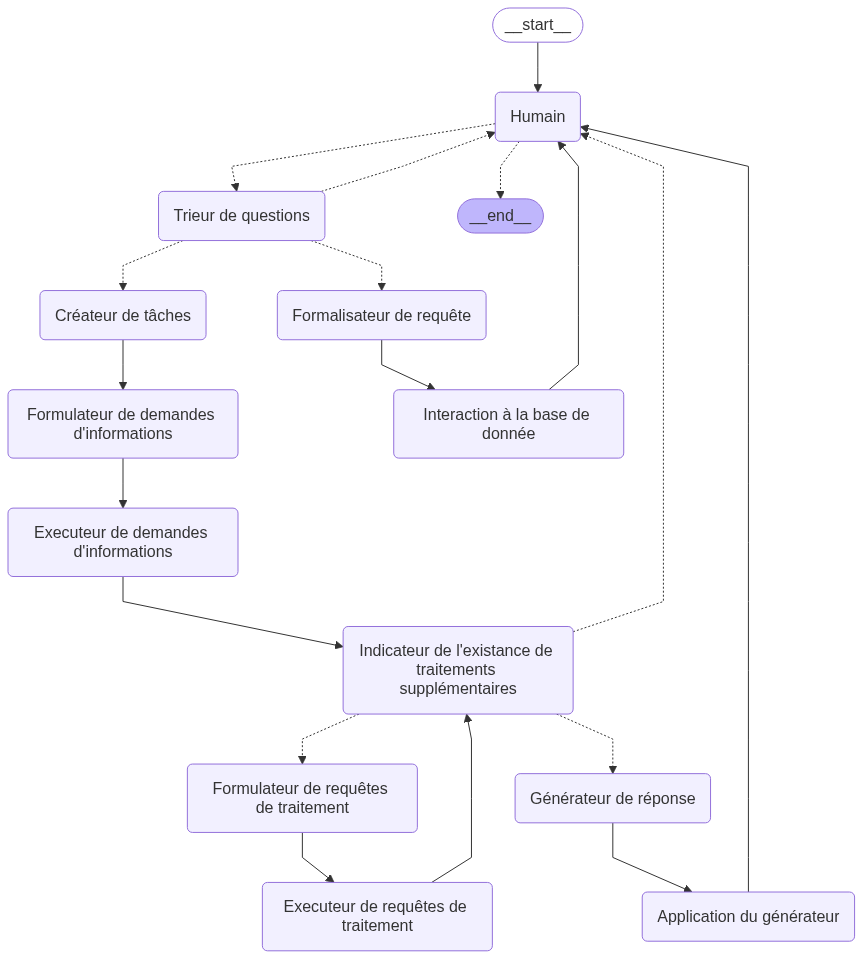

In [44]:
from IPython.display import Image

Image(chat_with_human_graph.get_graph().draw_mermaid_png())


Création du graphe d'agents intéragissant entre eux

In [45]:
if __name__ == "__main__":
    app = QApplication(sys.argv)
    
    controller = ChatController()
    view = ChatWindow(controller)
    controller.view = view
    view.show()
    sys.exit(app.exec())


🎨 Thème appliqué : dark
Input token : 0
Output_token : 0
Prix Input token : 0
Prix Output_token : 0
[Utilisateur]: Liste les programmes et leur cycle associé
Nous sommes le 2025-07-08 16:13:56.024281
state : False
Réponse brute : {'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'OHQoONsVR', 'function': {'name': 'OutputSchema', 'arguments': '{"result": true}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 1760, 'total_tokens': 1770, 'completion_tokens': 10}, 'model_name': 'mistral-medium-latest', 'model': 'mistral-medium-latest', 'finish_reason': 'tool_calls'}, id='run--f3055bd3-13ed-4ada-863b-9c7f2b5ca611-0', tool_calls=[{'name': 'OutputSchema', 'args': {'result': True}, 'id': 'OHQoONsVR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1760, 'output_tokens': 10, 'total_tokens': 1770}), 'parsed': OutputSchema(result=True), 'parsing_error': None}
✅ Question en relation avec Huron : True
Question en relation avec Huron : True

Informatio

SystemExit: 0

c:\Users\Gregory\Documents\GitHub\ia-assistant-supervision-industrielle\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [46]:
%tb

SystemExit: 0